In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import requests
import json
import time
import random
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast
from collections import Counter
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_original = pd.read_csv('/content/drive/My Drive/TFMSandoz/Datos/DF_Final/DF_Final.csv')

In [4]:
df = df_original.copy()
df

,Patent,Patent_Name,Status,Most_Recent_Event_Date,Most_Recent_Event,Divisional_applications,Parent_applications,Inventors,Priority_numbers,Applicants,Representatives,IPC,CPC,Opponent,Publications,patent_family,counterType_patent_family,firstDate_patent_family,lastDate_patent_family
0,EP0721594,AUTONOMOUS CRUISE CONTROL,No opposition filed within time limit,28.12.2007,Lapse of the patent in a contracting state\nNe...,"[{""EP01109826.6"": ""EP1167108""}]",[],"[{""number"": ""01"", ""name"": ""WOLL, Jerry"", ""addr...",[{'US19930130585': '01.10.1993'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""R\u00fcger Abel Patentanw\u00e4lte ...","[""G01S13/60, B60K31/00, G01S13/93<br/>""]","[""B60K31/0008 (EP,KR,US);"", ""B60W30/146 (EP);""...",[],"[{""Type"": ""A1\u00a0Application with search rep...","[{'Publication No.': 'JP3104998B', 'Date': '30...","{'B2': 1, 'A': 4, 'A1': 4, 'B1': 1, 'A4': 1, '...",1995-04-13,2003-05-08
1,EP0737549,Abrasive tape and process for producing it,No opposition filed within time limit,24.10.2003,No opposition filed within time limit,"[{""EP02012459.0"": ""EP1250983""}]",[],"[{""number"": ""01"", ""name"": ""Fujii, Kazuhito, c/...","[{'JP19950109088': '10.04.1995'}, {'JP19960005...","[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""M\u00fcller-Bor\u00e9 &amp; Partner...","[""B24D3/00, B24D11/00, B24D3/28<br/>""]","[""B24B19/226 (EP,US);"", ""B24D3/00 (KR);"", ""B24...",[],"[{""Type"": ""A2\u00a0Application without search ...",NaN,NaN,NaN,NaN
2,EP0788617,MINIATURE OPTICAL SCANNER FOR A TWO AXIS SCANN...,No opposition filed within time limit,04.01.2008,Lapse of the patent in a contracting state\nNe...,"[{""EP01202983.1"": ""EP1168032""}]",[],"[{""number"": ""01"", ""name"": ""MELVILLE, Charles, ...",[{'US19940329508': '26.10.1994'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Hitchcock, Esmond Antony"", ""address...","[""G02B26/08, G02B26/10, G02B7/182<br/>""]","[""G02B26/10 (EP,US);"", ""G02B26/101 (EP,US);"", ...",[],"[{""Type"": ""A1\u00a0Application with search rep...","[{'Publication No.': 'JP2001523350', 'Date': '...","{'A': 4, 'A3': 1, 'A2': 1, 'B1': 2, 'A4': 1, '...",1996-05-09,2006-08-22
3,EP0885233,TERPYRIDINE-PLATINUM(II) COMPLEXES,No opposition filed within time limit,25.04.2003,No opposition filed within time limit,"[{""EP01121776.7"": ""EP1164138""}]",[],"[{""number"": ""01"", ""name"": ""LOWE, Gordon"", ""add...",[{'GB19960001603': '26.01.1996'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Ellis-Jones, Patrick George Armine,...","[""C07F15/00, C07D213/06, C07D213/22, C07H19/06...","[""C07H21/00 (EP,US);"", ""A61P33/00 (EP);"", ""A61...",[],"[{""Type"": ""A1\u00a0Application with search rep...",NaN,NaN,NaN,NaN
4,EP1105513,METHODS AND COMPOSITIONS FOR USE IN SPLICEOSOM...,The application is deemed to be withdrawn,14.01.2005,Application deemed to be withdrawn,"[{""EP04077408.5"": ""EP1489185""}]",[],"[{""number"": ""01"", ""name"": ""MITCHELL, Lloyd, G....","[{'US19980133717': '13.08.1998'}, {'US19980158...","[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Lucas, Brian Ronald"", ""address_line...","[""C12N15/90, A61K48/00, C12N15/11, // A61P11:0...","[""C12N15/1027 (EP,US);"", ""A61K48/00 (EP,US);"",...",[],"[{""Type"": ""A2\u00a0Application without search ...","[{'Publication No.': 'WO9722250', 'Date': '26....","{'A1': 21, 'A3': 3, 'A2': 6, 'A': 13, 'B2': 8,...",1997-06-26,2015-11-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,EP3937083,SMART METAL CARD WITH RADIO FREQUENCY (RF) TRA...,Examination is in progress,15.11.2023,New entry: Renewal fee paid,[],"[{""EP15874266.8"": ""EP3238139""}]","[{""number"": ""01"", ""name"": ""HERSLOW, John"", ""ad...",[{'US201462095901P': '23.12.2014'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Scheele Jaeger Wetzel Patentanw\u00...","[""G06K19/077, G06K19/06<

# Patent Family Region Data (pre agrupado)

In [5]:
df_patent_family = df_original[["Patent", "patent_family"]]
df_patent_family

,Patent,patent_family
0,EP0721594,"[{'Publication No.': 'JP3104998B', 'Date': '30..."
1,EP0737549,NaN
2,EP0788617,"[{'Publication No.': 'JP2001523350', 'Date': '..."
3,EP0885233,NaN
4,EP1105513,"[{'Publication No.': 'WO9722250', 'Date': '26...."
...,...,...
143,EP3937083,"[{'Publication No.': 'US9898699', 'Date': '20...."
144,EP3992203,"[{'Publication No.': 'US9725732', 'Date': '08...."
145,EP4036079,"[{'Publication No.': 'US2021161829', 'Date': '..."
146,EP4215191,"[{'Publication No.': 'US2019008817', 'Date': '..."


In [6]:
# Función para analizar una familia de patentes
def analizar_familia_patentes(patent_family):
    # Inicializar contadores
    total_A = 0  # Total de registros (A)
    total_B = 0  # Total de registros concedidos (B)
    region_data = {}

    # Patrones regex para identificar tipos A y B
    pattern_A = re.compile(r'^A\d*$')  # Coincide con A, A1, A2, etc.
    pattern_B = re.compile(r'^B\d*$')  # Coincide con B, B1, B2, etc.

    # Análisis de cada patente en la familia
    for patent in patent_family:
        pub_no = patent['Publication No.']
        p_type = patent['Type']

        # Identificar región por el prefijo del número de publicación
        region = pub_no[:2]

        # Inicializar región si no existe
        if region not in region_data:
            region_data[region] = {'A': 0, 'B': 0}

        # Contar el total (A) y concedidos (B) por región
        if pattern_A.match(p_type):
            region_data[region]['A'] += 1
            total_A += 1
        elif pattern_B.match(p_type):
            region_data[region]['B'] += 1
            total_B += 1
            #region_data[region]['A'] += 1  # Contamos también como A para total_A
            #total_A += 1

    # Calcular la tasa de éxito para cada región
    for region in region_data:
        A = region_data[region]['A']
        B = region_data[region]['B']
        success_rate = (B / A) * 100 if A > 0 else 0
        region_data[region]['Success Rate'] = success_rate

    # Calcular la tasa de éxito total
    total_success_rate = (total_B / total_A) * 100 if total_A > 0 else 0

    return total_A, total_B, total_success_rate, region_data

# Convertir la columna 'patent_family' de cadenas a listas de diccionarios
df_patent_family['patent_family'] = df_patent_family['patent_family'].apply(lambda x: literal_eval(x) if pd.notna(x) else [])

# Aplicar la función a cada familia de patentes en el DataFrame
df_patent_family['Total_A'], df_patent_family['Total_B'], df_patent_family['Total_Success_Rate'], df_patent_family['Region_Data'] = zip(*df_patent_family['patent_family'].apply(analizar_familia_patentes))

<ipython-input-6-6a238e14c622>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patent_family['patent_family'] = df_patent_family['patent_family'].apply(lambda x: literal_eval(x) if pd.notna(x) else [])
<ipython-input-6-6a238e14c622>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patent_family['Total_A'], df_patent_family['Total_B'], df_patent_family['Total_Success_Rate'], df_patent_family['Region_Data'] = zip(*df_patent_family['patent_family'].apply(analizar_familia_patentes))
<ipython-input-6-6a

In [7]:
# Imprimir el DataFrame con los resultados
df_patent_family[['Patent', 'patent_family', 'Total_A', 'Total_B', 'Total_Success_Rate', 'Region_Data']]


,Patent,patent_family,Total_A,Total_B,Total_Success_Rate,Region_Data
0,EP0721594,"[{'Publication No.': 'JP3104998B', 'Date': '30...",9,2,22.222222,"{'JP': {'A': 1, 'B': 1, 'Success Rate': 100.0}..."
1,EP0737549,[],0,0,0.000000,{}
2,EP0788617,"[{'Publication No.': 'JP2001523350', 'Date': '...",11,2,18.181818,"{'JP': {'A': 1, 'B': 0, 'Success Rate': 0.0}, ..."
3,EP0885233,[],0,0,0.000000,{}
4,EP1105513,"[{'Publication No.': 'WO9722250', 'Date': '26....",46,10,21.739130,"{'WO': {'A': 8, 'B': 0, 'Success Rate': 0.0}, ..."
...,...,...,...,...,...,...
143,EP3937083,"[{'Publication No.': 'US9898699', 'Date': '20....",7,3,42.857143,"{'US': {'A': 2, 'B': 2, 'Success Rate': 100.0}..."
144,EP3992203,"[{'Publication No.': 'US9725732', 'Date': '08....",19,8,42.105263,"{'US': {'A': 6, 'B': 5, 'Success Rate': 83.333..."
145,EP4036079,"[{'Publication No.': 'US2021161829', 'Date': '...",12,8,66.666667,"{'US': {'A': 3, 'B': 2, 'Success Rate': 66.666..."
146,EP4215191,"[{'Publication No.': 'US2019008817', 'Date': '...",36,12,33.333333,"{'US': {'A': 8, 'B': 5, 'Success Rate': 62.5},..."


In [8]:
df_patent_family["Region_Data"][0]

{'JP': {'A': 1, 'B': 1, 'Success Rate': 100.0},
 'EP': {'A': 3, 'B': 1, 'Success Rate': 33.33333333333333},
 'AT': {'A': 0, 'B': 0, 'Success Rate': 0},
 'BR': {'A': 1, 'B': 0, 'Success Rate': 0.0},
 'CA': {'A': 1, 'B': 0, 'Success Rate': 0.0},
 'DE': {'A': 0, 'B': 0, 'Success Rate': 0},
 'US': {'A': 1, 'B': 0, 'Success Rate': 0.0},
 'WO': {'A': 1, 'B': 0, 'Success Rate': 0.0},
 'KR': {'A': 1, 'B': 0, 'Success Rate': 0.0}}

In [9]:
# Inicializar un conjunto vacío para almacenar los códigos de país únicos
unique_countries = set()

# Iterar sobre cada fila del DataFrame
for region_data in df_patent_family['Region_Data']:
    # Agregar todos los códigos de país de cada fila al conjunto
    unique_countries.update(region_data.keys())

# Convertir el conjunto a una lista (opcional)
unique_countries_list = list(unique_countries)

# Imprimir la lista de códigos de país únicos
print(unique_countries_list)
print(len(unique_countries_list))


['GT', 'HK', 'ME', 'WO', 'SM', 'SA', 'CZ', 'ZA', 'SG', 'CR', 'DE', 'FI', 'LT', 'UY', 'KR', 'ES', 'PT', 'CO', 'AU', 'EC', 'SI', 'CA', 'CL', 'MY', 'MA', 'TR', 'NO', 'HU', 'AT', 'FR', 'AR', 'RS', 'JP', 'TN', 'LU', 'CY', 'NZ', 'UA', 'GE', 'HR', 'EP', 'US', 'CN', 'PL', 'BR', 'PE', 'PH', 'JO', 'EA', 'IT', 'IL', 'MX', 'RU', 'GB', 'TW', 'DK']
56


In [10]:
import pandas as pd

# Define lists of regions
europe = ['EP','AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE',
          'IS', 'IT', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK', 'SM', 'UA']
america = ['AR', 'BR', 'CA', 'CL', 'CO', 'CR', 'CU', 'EC', 'GT', 'MX', 'NI', 'PA', 'PE', 'SV', 'TT', 'US', 'UY']
asia = ['CN', 'GE', 'HK', 'ID', 'IL', 'IN', 'JP', 'KR', 'MY', 'PH', 'SG', 'TJ', 'TR', 'TW', 'VN']
africa = ['DZ', 'EG', 'KE', 'MA', 'MW', 'ZA', 'ZM', 'ZW']
oceania = ['AU', 'NC', 'NZ']
wipo = ['WO']

def calcular_exposicion_regional(region_data):
    results = {region: {'A': 0, 'B': 0} for region in ['europe', 'america', 'asia', 'africa', 'oceania', 'wipo']}

    for country, data in region_data.items():
        if country in europe:
            results['europe']['A'] += data['A']
            results['europe']['B'] += data['B']
        elif country in america:
            results['america']['A'] += data['A']
            results['america']['B'] += data['B']
        elif country in asia:
            results['asia']['A'] += data['A']
            results['asia']['B'] += data['B']
        elif country in africa:
            results['africa']['A'] += data['A']
            results['africa']['B'] += data['B']
        elif country in oceania:
            results['oceania']['A'] += data['A']
            results['oceania']['B'] += data['B']
        elif country in wipo:
            results['wipo']['A'] += data['A']
            results['wipo']['B'] += data['B']

    return results

# Apply the function to each row of the DataFrame
df_patent_family['Region_Results'] = df_patent_family['Region_Data'].apply(calcular_exposicion_regional)

regions = ['europe', 'america', 'asia', 'africa', 'oceania', 'wipo']

for region in regions:
    df_patent_family[f'num_{region}'] = df_patent_family['Region_Results'].apply(lambda x: x[region]['A'])
    df_patent_family[f'num_{region}_B'] = df_patent_family['Region_Results'].apply(lambda x: x[region]['B'])
    df_patent_family[f'patent_family_success_rate_{region}'] = df_patent_family.apply(
        lambda row: row[f'num_{region}_B'] / row[f'num_{region}'] if row[f'num_{region}'] != 0 else 0,
        axis=1
    )

# Calculate total exposure outside Europe
df_patent_family['num_no_europe'] = df_patent_family[[f'num_{region}' for region in regions if region != 'europe']].sum(axis=1)
df_patent_family['num_no_europe_B'] = df_patent_family[[f'num_{region}_B' for region in regions if region != 'europe']].sum(axis=1)

# Create binary variables to indicate whether there is more exposure in Europe than in the rest of the world.
df_patent_family['Exposicion_Europa_Mayor_Resto'] = (df_patent_family['num_europe'] > df_patent_family['num_no_europe']).astype(int)
df_patent_family['Exposicion_Europa_Mayor_Resto_B'] = (df_patent_family['num_europe_B'] > df_patent_family['num_no_europe_B']).astype(int)

# Calculate success rate for non-Europe and non-WIPO regions
non_europe_wipo_regions = ['america', 'asia', 'africa', 'oceania']
df_patent_family['num_non_europe_wipo'] = df_patent_family[[f'num_{region}' for region in non_europe_wipo_regions]].sum(axis=1)
df_patent_family['num_non_europe_wipo_B'] = df_patent_family[[f'num_{region}_B' for region in non_europe_wipo_regions]].sum(axis=1)

df_patent_family['patent_family_success_rate_non_europe'] = df_patent_family.apply(
    lambda row: row['num_non_europe_wipo_B'] / row['num_non_europe_wipo'] if row['num_non_europe_wipo'] != 0 else 0,
    axis=1
)

<ipython-input-10-a82662e4453e>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patent_family['Region_Results'] = df_patent_family['Region_Data'].apply(calcular_exposicion_regional)
<ipython-input-10-a82662e4453e>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patent_family[f'num_{region}'] = df_patent_family['Region_Results'].apply(lambda x: x[region]['A'])
<ipython-input-10-a82662e4453e>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [11]:
df_patent_family.drop(['patent_family',	'Region_Data',	'Region_Results'], axis=1, inplace=True)

In [12]:
df_patent_family

,Patent,Total_A,Total_B,Total_Success_Rate,num_europe,num_europe_B,patent_family_success_rate_europe,num_america,num_america_B,patent_family_success_rate_america,...,num_wipo,num_wipo_B,patent_family_success_rate_wipo,num_no_europe,num_no_europe_B,Exposicion_Europa_Mayor_Resto,Exposicion_Europa_Mayor_Resto_B,num_non_europe_wipo,num_non_europe_wipo_B,patent_family_success_rate_non_europe
0,EP0721594,9,2,22.222222,3,1,0.333333,3,0,0.000000,...,1,0,0.0,6,1,0,0,5,1,0.200000
1,EP0737549,0,0,0.000000,0,0,0.000000,0,0,0.000000,...,0,0,0.0,0,0,0,0,0,0,0.000000
2,EP0788617,11,2,18.181818,4,1,0.250000,4,1,0.250000,...,1,0,0.0,7,1,0,0,6,1,0.166667
3,EP0885233,0,0,0.000000,0,0,0.000000,0,0,0.000000,...,0,0,0.0,0,0,0,0,0,0,0.000000
4,EP1105513,46,10,21.739130,7,2,0.285714,17,1,0.058824,...,8,0,0.0,39,8,0,0,31,8,0.258065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,EP3937083,7,3,42.857143,3,1,0.333333,2,2,1.000000,...,2,0,0.0,4,2,0,0,2,2,1.000000
144,EP3992203,19,8,42.105263,4,2,0.500000,9,5,0.555556,...,2,0,0.0,15,6,0,0,13,6,0.461538
145,EP4036079,12,8,66.666667,3,2,0.666667,4,2,0.500000,...,1,0,0.0,9,6,0,0,8,6,0.750000
146,EP4215191,36,12,33.333333,3,0,0.000000,10,5,0.500000,...,1,0,0.0,31,11,0,0,30,11,0.366667


In [13]:
df = pd.merge(df, df_patent_family, on='Patent')

# Divisional applications

In [14]:
df

,Patent,Patent_Name,Status,Most_Recent_Event_Date,Most_Recent_Event,Divisional_applications,Parent_applications,Inventors,Priority_numbers,Applicants,...,num_wipo,num_wipo_B,patent_family_success_rate_wipo,num_no_europe,num_no_europe_B,Exposicion_Europa_Mayor_Resto,Exposicion_Europa_Mayor_Resto_B,num_non_europe_wipo,num_non_europe_wipo_B,patent_family_success_rate_non_europe
0,EP0721594,AUTONOMOUS CRUISE CONTROL,No opposition filed within time limit,28.12.2007,Lapse of the patent in a contracting state\nNe...,"[{""EP01109826.6"": ""EP1167108""}]",[],"[{""number"": ""01"", ""name"": ""WOLL, Jerry"", ""addr...",[{'US19930130585': '01.10.1993'}],"[{""type"": ""current"", ""for"": ""For all designate...",...,1,0,0.0,6,1,0,0,5,1,0.200000
1,EP0737549,Abrasive tape and process for producing it,No opposition filed within time limit,24.10.2003,No opposition filed within time limit,"[{""EP02012459.0"": ""EP1250983""}]",[],"[{""number"": ""01"", ""name"": ""Fujii, Kazuhito, c/...","[{'JP19950109088': '10.04.1995'}, {'JP19960005...","[{""type"": ""current"", ""for"": ""For all designate...",...,0,0,0.0,0,0,0,0,0,0,0.000000
2,EP0788617,MINIATURE OPTICAL SCANNER FOR A TWO AXIS SCANN...,No opposition filed within time limit,04.01.2008,Lapse of the patent in a contracting state\nNe...,"[{""EP01202983.1"": ""EP1168032""}]",[],"[{""number"": ""01"", ""name"": ""MELVILLE, Charles, ...",[{'US19940329508': '26.10.1994'}],"[{""type"": ""current"", ""for"": ""For all designate...",...,1,0,0.0,7,1,0,0,6,1,0.166667
3,EP0885233,TERPYRIDINE-PLATINUM(II) COMPLEXES,No opposition filed within time limit,25.04.2003,No opposition filed within time limit,"[{""EP01121776.7"": ""EP1164138""}]",[],"[{""number"": ""01"", ""name"": ""LOWE, Gordon"", ""add...",[{'GB19960001603': '26.01.1996'}],"[{""type"": ""current"", ""for"": ""For all designate...",...,0,0,0.0,0,0,0,0,0,0,0.000000
4,EP1105513,METHODS AND COMPOSITIONS FOR USE IN SPLICEOSOM...,The application is deemed to be withdrawn,14.01.2005,Application deemed to be withdrawn,"[{""EP04077408.5"": ""EP1489185""}]",[],"[{""number"": ""01"", ""name"": ""MITCHELL, Lloyd, G....","[{'US19980133717': '13.08.1998'}, {'US19980158...","[{""type"": ""current"", ""for"": ""For all designate...",...,8,0,0.0,39,8,0,0,31,8,0.258065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,EP3937083,SMART METAL CARD WITH RADIO FREQUENCY (RF) TRA...,Examination is in progress,15.11.2023,New entry: Renewal fee paid,[],"[{""EP15874266.8"": ""EP3238139""}]","[{""number"": ""01"", ""name"": ""HERSLOW, John"", ""ad...",[{'US201462095901P': '23.12.2014'}],"[{""type"": ""current"", ""for"": ""For all designate...",...,2,0,0.0,4,2,0,0,2,2,1.000000
144,EP3992203,PLANT CYTOCHROME P450,Request for examination was made,29.07.2024,New entry: Renewal fee paid,[],"[{""EP11748702.5"": ""EP2596012""}, {""EP16186318.8...","[{""number"": ""01"", ""name"": ""WINZER, Thilo"", ""ad...","[{'GB20100021707': '22.07.2010'}, {'GB20100012...","[{""type"": ""current"", ""for"": ""For all designate...",...,2,0,0.0,15,6,0,0,13,6,0.461538
145,EP4036079,COMPOUNDS AND COMPOSITIONS FOR INTRACELLULAR D...,Examination is in progress,09.07.2024,New entry: Reply to examination report,[],"[{""EP16831870.7"": ""EP3394030""}]","[{""number"": ""01"", ""name"": ""BENENATO, Kerry E.""...","[{'US201562271160P': '22.12.2015'}, {'US201562...","[{""type"": ""current"", ""for"": ""For all designate...",...,1,0,0.0,9,6,0,0,8,6,0.750000
146,EP4215191,COMPOSITION COMPRISING A FUMARATE FOR USE IN A...,Request for examination was made,02.02.2024,The date on which the examining division becom...,[],"[{""EP15804260.6"": ""EP3220907""}, {""EP20195649.7...","[{""number"": ""01"", ""name"": ""Novas, Mark"", ""addr...","[{'US201462080783P': '17.11.2014'}, {'US201562...","[{""type"": ""current"", ""for"": ""For all designate...",...,1,0,0.0,31,11,0,0,30,11,0.366667


In [15]:
# divisional applications binary

def is_list_filled(lista_str):
    lista_str = lista_str.strip()[1:-1].strip()
    return 1 if lista_str else 0

df['divisional_binary'] = df['Divisional_applications'].apply(is_list_filled)

In [16]:
# separar claves y valores de divisional applications en dos columnas:
# divisional_application_number
# divisional_publication_number

# Función para extraer claves y valores
def extract_keys_values(entry):
    if isinstance(entry, str):
        # Convertir la cadena en una lista de diccionarios
        entry = ast.literal_eval(entry)
    keys = []
    values = []
    for dic in entry:
        for k, v in dic.items():
            keys.append(k)
            values.append(v)
    return pd.Series([keys, values])

# Aplicar la función a la columna y crear dos columnas nuevas
df[['divisional_application_number', 'divisional_publication_number']] = df['Divisional_applications'].apply(extract_keys_values)

# Si quieres que las listas resultantes sean cadenas de texto (opcional)
df['divisional_application_number'] = df['divisional_application_number'].apply(lambda x: ', '.join(x))
df['divisional_publication_number'] = df['divisional_publication_number'].apply(lambda x: ', '.join(x))


# Parent applications


In [17]:
# parent applications binary

df['parent_binary'] = df['Parent_applications'].apply(is_list_filled)


In [18]:
# separar claves y valores de parent applications en dos columnas:
# parent_application_number
# parent_publication_number

import ast

# Función para extraer claves y valores
def extract_keys_values(entry):
    if isinstance(entry, str):
        # Convertir la cadena en una lista de diccionarios
        entry = ast.literal_eval(entry)
    keys = []
    values = []
    for dic in entry:
        for k, v in dic.items():
            keys.append(k)
            values.append(v)
    return pd.Series([keys, values])

# Aplicar la función a la columna y crear dos columnas nuevas
df[['parent_application_number', 'parent_publication_number']] = df['Parent_applications'].apply(extract_keys_values)

# Si quieres que las listas resultantes sean cadenas de texto (opcional)
df['parent_application_number'] = df['parent_application_number'].apply(lambda x: ', '.join(x))
df['parent_publication_number'] = df['parent_publication_number'].apply(lambda x: ', '.join(x))

In [19]:
df = df.drop(columns=['Divisional_applications', 'Parent_applications'])

In [20]:
df[['Patent','parent_publication_number']]

,Patent,parent_publication_number
0,EP0721594,
1,EP0737549,
2,EP0788617,
3,EP0885233,
4,EP1105513,
...,...,...
143,EP3937083,EP3238139
144,EP3992203,"EP2596012, EP3121193"
145,EP4036079,EP3394030
146,EP4215191,"EP3220907, EP3804711"


In [21]:
def find_descendants(df, patent, family_id):
    stack = [patent]
    while stack:
        current_patent = stack.pop()
        if pd.isna(df.loc[df['Patent'] == current_patent, 'family_id'].iloc[0]):
            df.loc[df['Patent'] == current_patent, 'family_id'] = family_id

            divisionals = df.loc[
                (df['parent_publication_number'].notna()) &
                (df['parent_publication_number'] != '') &
                (df['parent_publication_number'].str.contains(current_patent, na=False, regex=False)),
                'Patent'
            ]
            stack.extend(divisionals.tolist())

df['family_id'] = np.nan

patriarchs = df[df['parent_publication_number'].isna() | (df['parent_publication_number'] == '')]['Patent']

In [22]:
patriarchs

,Patent
0,EP0721594
1,EP0737549
2,EP0788617
3,EP0885233
4,EP1105513
...,...
113,EP3220907
116,EP3238139
117,EP3238209
118,EP3238235


In [23]:
family_counter = 1

for patriarch in patriarchs:
    if pd.isna(df.loc[df['Patent'] == patriarch, 'family_id'].iloc[0]):
        family_id = family_counter
        find_descendants(df, patriarch, family_id)
        family_counter += 1

num_families = df['family_id'].nunique()
print(f"Número total de familias identificadas: {num_families}")

Número total de familias identificadas: 65


In [24]:
import pandas as pd

# Función para manejar diferentes tipos de datos
def agregar_y_limpiar(x):
    if isinstance(x.iloc[0], (int, float)):
        return list(set(x))
    elif isinstance(x.iloc[0], dict):
        return [dict(t) for t in {tuple(d.items()) for d in x}]
    else:
        return list(set(x))

# Agrupar el DataFrame
df_agrupado = df.groupby('family_id').agg(agregar_y_limpiar).reset_index()

# Función para simplificar las listas de un solo elemento
def simplificar(x):
    if isinstance(x, list) and len(x) == 1:
        return x[0]
    return x

# Aplicar la simplificación a todas las columnas excepto 'family_id'
for col in df_agrupado.columns:
    if col != 'family_id':
        df_agrupado[col] = df_agrupado[col].apply(simplificar)

In [25]:
df_agrupado

,family_id,Patent,Patent_Name,Status,Most_Recent_Event_Date,Most_Recent_Event,Inventors,Priority_numbers,Applicants,Representatives,...,Exposicion_Europa_Mayor_Resto_B,num_non_europe_wipo,num_non_europe_wipo_B,patent_family_success_rate_non_europe,divisional_binary,divisional_application_number,divisional_publication_number,parent_binary,parent_application_number,parent_publication_number
0,1.0,"[EP1167108, EP0721594]","[AUTONOMOUS CRUISE CONTROL, Autonomous cruise ...","[The application is deemed to be withdrawn, No...","[22.08.2003, 28.12.2007]",[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""WOLL, Jerry"", ""add...",[{'US19930130585': '01.10.1993'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""R\u00fcger Abel Patentanw\u00e4lte...",...,0,5,1,0.2,"[0, 1]","[, EP01109826.6]","[EP1167108, ]","[0, 1]","[, EP94928670.2]","[, EP0721594]"
1,2.0,"[EP1250983, EP0737549]","[Abrasive tape and process for producing it, A...","[The application is deemed to be withdrawn, No...","[22.01.2010, 24.10.2003]","[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""Fujii, Kazuhito, c...","[{'JP19950109088': '10.04.1995'}, {'JP19960005...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""M\u00fcller-Bor\u00e9 &amp; Partner...",...,0,"[0, 8]","[0, 4]","[0.0, 0.5]","[0, 1]","[, EP02012459.0]","[, EP1250983]","[0, 1]","[, EP96105584.5]","[, EP0737549]"
2,3.0,"[EP1168032, EP0788617]",[MINIATURE OPTICAL SCANNER FOR A TWO AXIS SCAN...,"[The application is deemed to be withdrawn, No...","[04.01.2008, 05.11.2004]",[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""MELVILLE, Charles,...",[{'US19940329508': '26.10.1994'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Hitchcock, Esmond Antony"", ""address...",...,0,6,1,0.166667,"[0, 1]","[, EP01202983.1]","[EP1168032, ]","[0, 1]","[, EP95936227.8]","[, EP0788617]"
3,4.0,"[EP1164138, EP0885233]","[Terpyridine-platinum (II) complexes, TERPYRID...","[The application is deemed to be withdrawn, No...","[23.04.2004, 25.04.2003]","[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""LOWE, Gordon"", ""ad...",[{'GB19960001603': '26.01.1996'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Ellis-Jones, Patrick George Armine...",...,"[0, 1]","[0, 3]",0,0.0,"[0, 1]","[, EP01121776.7]","[, EP1164138]","[0, 1]","[, EP97901187.1]","[, EP0885233]"
4,5.0,"[EP1489185, EP1105513]",[METHODS AND COMPOSITIONS FOR USE IN SPLICEOSO...,The application is deemed to be withdrawn,"[29.12.2006, 14.01.2005]",Application deemed to be withdrawn,"[[{""number"": ""01"", ""name"": ""MITCHELL, Lloyd, G...","[{'US19980133717': '13.08.1998'}, {'US19980158...","[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Lucas, Brian Ronald"", ""address_lin...",...,0,31,8,0.258065,"[0, 1]","[, EP04077408.5]","[, EP1489185]","[0, 1]","[, EP99943690.0]","[, EP1105513]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,"[EP3804711, EP4215191, EP3220907]","[METHODS OF TREATING MULTIPLE SCLEROSIS, COMPO...","[The application has been refused, Request for...","[02.02.2024, 28.04.2023, 26.01.2024]","[Refusal of application, The date on which the...","[[{""number"": ""01"", ""name"": ""NOVAS, Mark"", ""add...","[{'US201462080783P': '17.11.2014'}, {'US201562...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""Pohlman, Sandra M."", ""address_line1...",...,0,30,11,0.366667,"[0, 1]","[, EP20195649.7, EP22214115.2]","[, EP3804711, EP4215191]","[0, 1]","[, EP15804260.6, EP20195649.7, EP15804260.6]","[, EP3220907, EP3804711, EP3220907]"
61,62.0,"[EP3238139, EP3937083]",SMART METAL CARD WITH RADIO FREQUENCY (RF) TRA...,"[No opposition filed within time limit, Examin...","[15.11.2023, 27.04.2024]","[New entry: Renewal fee paid, Lap

In [26]:
columns_to_drop = ['Patent', 'Patent_Name', 'divisional_application_number', 'divisional_publication_number',
                   'parent_application_number', 'parent_publication_number', 'parent_binary',
                   'divisional_binary']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [27]:
df_agrupado

,family_id,Status,Most_Recent_Event_Date,Most_Recent_Event,Inventors,Priority_numbers,Applicants,Representatives,IPC,CPC,...,num_wipo,num_wipo_B,patent_family_success_rate_wipo,num_no_europe,num_no_europe_B,Exposicion_Europa_Mayor_Resto,Exposicion_Europa_Mayor_Resto_B,num_non_europe_wipo,num_non_europe_wipo_B,patent_family_success_rate_non_europe
0,1.0,"[The application is deemed to be withdrawn, No...","[22.08.2003, 28.12.2007]",[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""WOLL, Jerry"", ""add...",[{'US19930130585': '01.10.1993'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""R\u00fcger Abel Patentanw\u00e4lte...","[[""G01S13/60, B60K31/00, G01S13/93<br/>""], [""B...","[""B60K31/0008 (EP,KR,US);"", ""B60W30/146 (EP);""...",...,1,0,0.0,6,1,0,0,5,1,0.2
1,2.0,"[The application is deemed to be withdrawn, No...","[22.01.2010, 24.10.2003]","[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""Fujii, Kazuhito, c...","[{'JP19950109088': '10.04.1995'}, {'JP19960005...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""M\u00fcller-Bor\u00e9 &amp; Partner...","[[""B24D3/00, B24D11/00, B24D3/28<br/>""], [""B24...","[""B24B19/226 (EP,US);"", ""B24D3/00 (KR);"", ""B24...",...,0,0,0.0,"[0, 8]","[0, 4]",0,0,"[0, 8]","[0, 4]","[0.0, 0.5]"
2,3.0,"[The application is deemed to be withdrawn, No...","[04.01.2008, 05.11.2004]",[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""MELVILLE, Charles,...",[{'US19940329508': '26.10.1994'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Hitchcock, Esmond Antony"", ""address...","[[""G02B26/08, G02B26/10, G02B7/182<br/>""], [""G...","[""G02B26/10 (EP,US);"", ""G02B26/101 (EP,US);"", ...",...,1,0,0.0,7,1,0,0,6,1,0.166667
3,4.0,"[The application is deemed to be withdrawn, No...","[23.04.2004, 25.04.2003]","[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""LOWE, Gordon"", ""ad...",[{'GB19960001603': '26.01.1996'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Ellis-Jones, Patrick George Armine...","[[""C07F15/00, C07D213/06, C07D213/22, C07H19/0...","[""C07H21/00 (EP,US);"", ""A61P33/00 (EP);"", ""A61...",...,"[0, 1]",0,0.0,"[0, 4]",0,0,"[0, 1]","[0, 3]",0,0.0
4,5.0,The application is deemed to be withdrawn,"[29.12.2006, 14.01.2005]",Application deemed to be withdrawn,"[[{""number"": ""01"", ""name"": ""MITCHELL, Lloyd, G...","[{'US19980133717': '13.08.1998'}, {'US19980158...","[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Lucas, Brian Ronald"", ""address_lin...","[[""C12N15/90, A61K48/00, C12N15/11, // A61P11:...","[""C12N15/1027 (EP,US);"", ""A61K48/00 (EP,US);"",...",...,8,0,0.0,39,8,0,0,31,8,0.258065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,"[The application has been refused, Request for...","[02.02.2024, 28.04.2023, 26.01.2024]","[Refusal of application, The date on which the...","[[{""number"": ""01"", ""name"": ""NOVAS, Mark"", ""add...","[{'US201462080783P': '17.11.2014'}, {'US201562...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""Pohlman, Sandra M."", ""address_line1...","[""A61K31/225, A61P25/02<br/>""]","[""A61K31/225 (EP,CN,IL,KR,US);"", ""A61K47/542 (...",...,1,0,0.0,31,11,0,0,30,11,0.366667
61,62.0,"[No opposition filed within time limit, Examin...","[15.11.2023, 27.04.2024]","[New entry: Renewal fee paid, Lapse of the pat...","[[{""number"": ""01"", ""name"": ""HERSLOW, John"", ""a...",[{'US201462095901P': '23.12.2014'}],"[[{""type"": ""current"", ""for"": ""For all designat...","[[{""name"": ""Scheele Jaeger Wetzel Patentanw\u0...","[[""G06K19/077, G06K19/06<br/>""], [""G06K19/06<b...","[""G06K19/07773 (EP,US);"", ""G06K19/02 (EP,US);""...",...,2,0,0.0,4,2,0,0,2,2,1.0
62,63.0,"[The application has been published, No opposi...","[02

# STATUS

- Inicialmente, nos enfrentamos a un DataFrame en Python con una columna llamada "status". Esta columna contenía, en cada fila, una lista de estados o un estado único.
- Primero, desarrollamos un código para extraer y contar todos los estados únicos en toda la columna. Esto implicó crear una función que pudiera manejar tanto listas de estados como estados individuales, y luego usar un contador para llevar un registro de cuántas veces aparecía cada estado en toda la columna.
- Luego, ampliamos esta funcionalidad para crear un análisis más detallado por fila. El objetivo era crear una nueva columna para cada tipo de estado único encontrado en todo el DataFrame.
Para lograr esto, primero identificamos todos los tipos de estados únicos en el DataFrame completo.
- Después, creamos una función que analiza cada fila individualmente, contando la ocurrencia de cada tipo de estado en esa fila específica.
- Aplicamos esta función a cada fila del DataFrame, lo que resultó en la creación de nuevas columnas, una para cada tipo de estado único.
- En estas nuevas columnas, cada celda contiene el recuento de cuántas veces aparece ese estado específico en esa fila. Si un estado no aparece en una fila particular, se registra como 0.
- Finalmente, estas nuevas columnas se añadieron al DataFrame original, creando un DataFrame ampliado que no solo contiene la información original, sino también un desglose detallado de la frecuencia de cada estado por fila.

In [28]:
df_agrupado['Status']

,Status
0,"[The application is deemed to be withdrawn, No..."
1,"[The application is deemed to be withdrawn, No..."
2,"[The application is deemed to be withdrawn, No..."
3,"[The application is deemed to be withdrawn, No..."
4,The application is deemed to be withdrawn
...,...
60,"[The application has been refused, Request for..."
61,"[No opposition filed within time limit, Examin..."
62,"[The application has been published, No opposi..."
63,The application has been refused


In [29]:
import pandas as pd
import ast
from collections import Counter
import numpy as np

def extract_statuses(status_value):
    if isinstance(status_value, list) or isinstance(status_value, np.ndarray):
        return [str(item) if not pd.isna(item) else 'nan' for item in status_value]
    elif pd.isna(status_value):
        return ['nan']
    elif isinstance(status_value, str):
        try:
            if status_value.strip().startswith('[') and status_value.strip().endswith(']'):
                return [str(item) if not pd.isna(item) else 'nan' for item in ast.literal_eval(status_value)]
            else:
                return [status_value]
        except:
            return [status_value]
    else:
        return [str(status_value)]

all_statuses = set()
for status in df_agrupado['Status']:
    all_statuses.update(extract_statuses(status))

# Convertimos todos los status a string y añadimos 'Status_' delante
all_statuses_prefixed = {'Status_' + str(status) for status in all_statuses}

def count_statuses(row):
    statuses = extract_statuses(row['Status'])
    counts = Counter(statuses)
    return pd.Series({'Status_' + str(status): counts.get(status, 0) for status in all_statuses})

status_counts = df_agrupado.apply(count_statuses, axis=1)

df_agrupado = pd.concat([df_agrupado, status_counts], axis=1)

df_agrupado

,family_id,Status,Most_Recent_Event_Date,Most_Recent_Event,Inventors,Priority_numbers,Applicants,Representatives,IPC,CPC,...,Status_The application has been withdrawn,Status_Request for examination was made,Status_The application is deemed to be withdrawn,Status_Patent maintained as amended,Status_No opposition filed within time limit,Status_Examination is in progress,Status_The application has been refused,Status_nan,Status_The patent has been granted,Status_The application has been published
0,1.0,"[The application is deemed to be withdrawn, No...","[22.08.2003, 28.12.2007]",[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""WOLL, Jerry"", ""add...",[{'US19930130585': '01.10.1993'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""R\u00fcger Abel Patentanw\u00e4lte...","[[""G01S13/60, B60K31/00, G01S13/93<br/>""], [""B...","[""B60K31/0008 (EP,KR,US);"", ""B60W30/146 (EP);""...",...,0,0,1,0,1,0,0,0,0,0
1,2.0,"[The application is deemed to be withdrawn, No...","[22.01.2010, 24.10.2003]","[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""Fujii, Kazuhito, c...","[{'JP19950109088': '10.04.1995'}, {'JP19960005...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""M\u00fcller-Bor\u00e9 &amp; Partner...","[[""B24D3/00, B24D11/00, B24D3/28<br/>""], [""B24...","[""B24B19/226 (EP,US);"", ""B24D3/00 (KR);"", ""B24...",...,0,0,1,0,1,0,0,0,0,0
2,3.0,"[The application is deemed to be withdrawn, No...","[04.01.2008, 05.11.2004]",[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""MELVILLE, Charles,...",[{'US19940329508': '26.10.1994'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Hitchcock, Esmond Antony"", ""address...","[[""G02B26/08, G02B26/10, G02B7/182<br/>""], [""G...","[""G02B26/10 (EP,US);"", ""G02B26/101 (EP,US);"", ...",...,0,0,1,0,1,0,0,0,0,0
3,4.0,"[The application is deemed to be withdrawn, No...","[23.04.2004, 25.04.2003]","[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""LOWE, Gordon"", ""ad...",[{'GB19960001603': '26.01.1996'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Ellis-Jones, Patrick George Armine...","[[""C07F15/00, C07D213/06, C07D213/22, C07H19/0...","[""C07H21/00 (EP,US);"", ""A61P33/00 (EP);"", ""A61...",...,0,0,1,0,1,0,0,0,0,0
4,5.0,The application is deemed to be withdrawn,"[29.12.2006, 14.01.2005]",Application deemed to be withdrawn,"[[{""number"": ""01"", ""name"": ""MITCHELL, Lloyd, G...","[{'US19980133717': '13.08.1998'}, {'US19980158...","[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Lucas, Brian Ronald"", ""address_lin...","[[""C12N15/90, A61K48/00, C12N15/11, // A61P11:...","[""C12N15/1027 (EP,US);"", ""A61K48/00 (EP,US);"",...",...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,"[The application has been refused, Request for...","[02.02.2024, 28.04.2023, 26.01.2024]","[Refusal of application, The date on which the...","[[{""number"": ""01"", ""name"": ""NOVAS, Mark"", ""add...","[{'US201462080783P': '17.11.2014'}, {'US201562...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""Pohlman, Sandra M."", ""address_line1...","[""A61K31/225, A61P25/02<br/>""]","[""A61K31/225 (EP,CN,IL,KR,US);"", ""A61K47/542 (...",...,0,1,1,0,0,0,1,0,0,0
61,62.0,"[No opposition filed within time limit, Examin...","[15.11.2023, 27.04.2024]","[New entry: Renewal fee paid, Lapse of the pat...","[[{""number"": ""01"", ""name"": ""HERSLOW, John"", ""a...",[{'US201462095901P': '23.12.2014'}],"[[{""type"": ""current"", ""for"": ""For all designat...","[[{""name"": ""Scheele Jaeger Wetzel Patentanw\u0...","[[""G06K19/077, G06K19/06<br/>""], [""G06K19/06<b...","[""G06K19/07773 (EP,US);"", ""G06K19/02 (EP,US);""...",...,0,0,0,0,1,1,0,0,0,0
62,63.0,"[The application ha

In [30]:
len(df_agrupado.columns)

56

In [31]:
def calculate_new_columns(df):
    # Calcular el porcentaje de revocados
    total_estados = df[['Status_' + str(status) for status in all_statuses]].sum(axis=1)
    no_revocados = df['Status_No opposition filed within time limit']
    df['percentage_revoked'] = 1 - (no_revocados / total_estados)

    # Determinar si todos los estados son revocados
    df['totally_revoked'] = ((df['Status_No opposition filed within time limit'] == 0) & (total_estados > 0)).astype(int)

    return df

df_agrupado = calculate_new_columns(df_agrupado)

In [32]:
df_agrupado['totally_revoked'].unique()

array([0, 1])

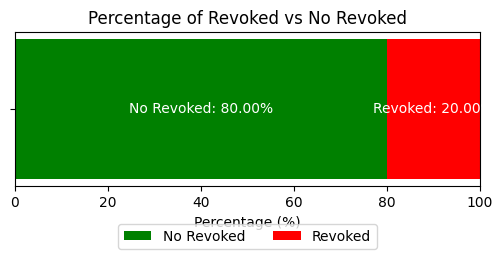

In [33]:
import pandas as pd
import matplotlib.pyplot as plt


df_agrupado_copy = df_agrupado.copy()

df_agrupado_copy['totally_revoked'] = df_agrupado_copy['totally_revoked'].replace({1: 'Revoked', 0: 'No Revoked'})

percentages = df_agrupado_copy['totally_revoked'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 2))

plt.barh([''], percentages['No Revoked'], color='green', label='No Revoked')
plt.barh([''], percentages['Revoked'], left=percentages['No Revoked'], color='red', label='Revoked')

plt.title('Percentage of Revoked vs No Revoked')
plt.xlim(0, 100)
plt.xlabel('Percentage (%)')

plt.text(percentages['No Revoked'] / 2, 0, f'No Revoked: {percentages["No Revoked"]:.2f}%', va='center', ha='center', color='white')
plt.text(percentages['No Revoked'] + percentages['Revoked'] / 2, 0, f'Revoked: {percentages["Revoked"]:.2f}%', va='center', ha='center', color='white')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.show()


In [34]:
df_agrupado['totally_revoked'].value_counts()

,count
totally_revoked,
0,52
1,13


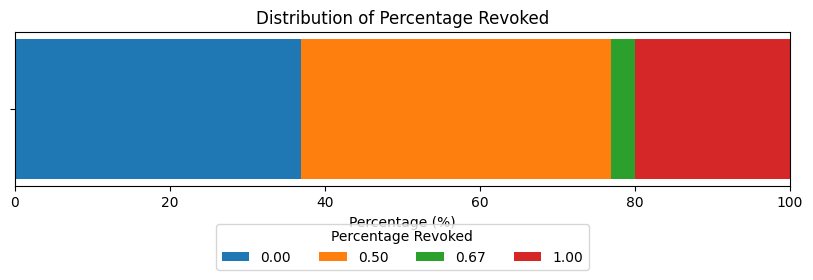

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df_agrupado_copy = df_agrupado.copy()
percentages = df_agrupado_copy['percentage_revoked'].value_counts(normalize=True) * 100
percentages = percentages.sort_index()
plt.figure(figsize=(10, 2))
left = 0
for value, percentage in percentages.items():
    plt.barh([''], percentage, left=left, label=f'{value:.2f}', height=0.5)
    left += percentage

plt.title('Distribution of Percentage Revoked')
plt.xlim(0, 100)
plt.xlabel('Percentage (%)')
plt.legend(title='Percentage Revoked', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=5)
plt.show()


In [36]:
df_agrupado['percentage_revoked'].value_counts()
#Tiene sentido el resultado ya que las familias son de 2, 3 o 4 patentes

,count
percentage_revoked,
0.500000,26
0.000000,24
1.000000,13
0.666667,2


In [37]:
df_agrupado.columns

Index(['family_id', 'Status', 'Most_Recent_Event_Date', 'Most_Recent_Event',
       'Inventors', 'Priority_numbers', 'Applicants', 'Representatives', 'IPC',
       'CPC', 'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family', 'firstDate_patent_family',
       'lastDate_patent_family', 'Total_A', 'Total_B', 'Total_Success_Rate',
       'num_europe', 'num_europe_B', 'patent_family_success_rate_europe',
       'num_america', 'num_america_B', 'patent_family_success_rate_america',
       'num_asia', 'num_asia_B', 'patent_family_success_rate_asia',
       'num_africa', 'num_africa_B', 'patent_family_success_rate_africa',
       'num_oceania', 'num_oceania_B', 'patent_family_success_rate_oceania',
       'num_wipo', 'num_wipo_B', 'patent_family_success_rate_wipo',
       'num_no_europe', 'num_no_europe_B', 'Exposicion_Europa_Mayor_Resto',
       'Exposicion_Europa_Mayor_Resto_B', 'num_non_europe_wipo',
       'num_non_europe_wipo_B', 'patent_family_success_rate_non_e

In [38]:
#df_agrupado = df_agrupado.drop(columns=['Status_nan'])

In [39]:
columns_to_drop = ['Status']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

# Most_Recent_Event_Date, firstDate_patent_family, lastDate_patent_family

In [40]:
df_agrupado['Most_Recent_Event_Date']

,Most_Recent_Event_Date
0,"[22.08.2003, 28.12.2007]"
1,"[22.01.2010, 24.10.2003]"
2,"[04.01.2008, 05.11.2004]"
3,"[23.04.2004, 25.04.2003]"
4,"[29.12.2006, 14.01.2005]"
...,...
60,"[02.02.2024, 28.04.2023, 26.01.2024]"
61,"[15.11.2023, 27.04.2024]"
62,"[02.08.2024, 15.03.2024]"
63,"[30.09.2022, 25.06.2021]"


In [41]:
import pandas as pd
import numpy as np
from ast import literal_eval
from datetime import datetime

def to_list(x):
    if isinstance(x, str):
        try:
            return literal_eval(x)
        except:
            return [x]
    elif isinstance(x, (list, np.ndarray, pd.Series)):
        return list(x)
    elif pd.isna(x):
        return []
    return [x]

def to_date(date_str):
    if isinstance(date_str, str):
        try:
            return datetime.strptime(date_str.strip(), '%d.%m.%Y')
        except ValueError:
            return pd.NaT
    elif pd.isna(date_str):
        return pd.NaT
    else:
        return pd.to_datetime(date_str)

# Aplicar las funciones al DataFrame
df_agrupado['Most_Recent_Event_Date'] = df_agrupado['Most_Recent_Event_Date'].apply(to_list)
df_agrupado['Most_Recent_Event_Date'] = df_agrupado['Most_Recent_Event_Date'].apply(
    lambda x: max((to_date(d) for d in x), default=datetime.now().date())
)

In [42]:
df_agrupado['Most_Recent_Event_Date']

,Most_Recent_Event_Date
0,2007-12-28
1,2010-01-22
2,2008-01-04
3,2004-04-23
4,2006-12-29
...,...
60,2024-02-02
61,2024-04-27
62,2024-08-02
63,2022-09-30


In [43]:
df_agrupado[['firstDate_patent_family', 'lastDate_patent_family']]

,firstDate_patent_family,lastDate_patent_family
0,1995-04-13,2003-05-08
1,"[nan, 1996-10-16]","[nan, 2005-07-27]"
2,1996-05-09,2006-08-22
3,"[1996-03-27, nan]","[nan, 2002-11-16]"
4,1997-06-26,2015-11-24
...,...,...
60,2016-05-26,2024-06-13
61,2016-06-23,2022-04-11
62,2012-11-15,2024-04-17
63,2016-06-30,2022-12-30


In [44]:
def get_oldest_date(cell):
    if isinstance(cell, list):
        valid_dates = [pd.to_datetime(date) for date in cell if pd.notna(date)]
        return min(valid_dates) if valid_dates else np.nan
    elif pd.notna(cell):
        return pd.to_datetime(cell)
    else:
        return np.nan

def get_youngest_date(cell):
    if isinstance(cell, list):
        valid_dates = [pd.to_datetime(date) for date in cell if pd.notna(date)]
        return max(valid_dates) if valid_dates else np.nan
    elif pd.notna(cell):
        return pd.to_datetime(cell)
    else:
        return np.nan

df_agrupado['firstDate_patent_family'] = df_agrupado['firstDate_patent_family'].apply(get_oldest_date)
df_agrupado['lastDate_patent_family'] = df_agrupado['lastDate_patent_family'].apply(get_youngest_date)

In [45]:
df_agrupado[['firstDate_patent_family','lastDate_patent_family']]

,firstDate_patent_family,lastDate_patent_family
0,1995-04-13,2003-05-08
1,1996-10-16,2005-07-27
2,1996-05-09,2006-08-22
3,1996-03-27,2002-11-16
4,1997-06-26,2015-11-24
...,...,...
60,2016-05-26,2024-06-13
61,2016-06-23,2022-04-11
62,2012-11-15,2024-04-17
63,2016-06-30,2022-12-30


In [46]:
date_columns = ['Most_Recent_Event_Date', 'firstDate_patent_family', 'lastDate_patent_family']
def add_time_columns(df, date_column):
    df[f'{date_column}_year'] = df[date_column].dt.year
    df[f'{date_column}_month'] = df[date_column].dt.month
    df[f'{date_column}_quarter'] = df[date_column].dt.quarter
    df[f'{date_column}_semester'] = ((df[date_column].dt.month - 1) // 6) + 1
    return df

for col in date_columns:
    df = add_time_columns(df_agrupado, col)

In [47]:
df_agrupado

,family_id,Most_Recent_Event_Date,Most_Recent_Event,Inventors,Priority_numbers,Applicants,Representatives,IPC,CPC,Opponent,...,Most_Recent_Event_Date_quarter,Most_Recent_Event_Date_semester,firstDate_patent_family_year,firstDate_patent_family_month,firstDate_patent_family_quarter,firstDate_patent_family_semester,lastDate_patent_family_year,lastDate_patent_family_month,lastDate_patent_family_quarter,lastDate_patent_family_semester
0,1.0,2007-12-28,[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""WOLL, Jerry"", ""add...",[{'US19930130585': '01.10.1993'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""R\u00fcger Abel Patentanw\u00e4lte...","[[""G01S13/60, B60K31/00, G01S13/93<br/>""], [""B...","[""B60K31/0008 (EP,KR,US);"", ""B60W30/146 (EP);""...",[],...,4,2,1995,4,2,1,2003,5,2,1
1,2.0,2010-01-22,"[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""Fujii, Kazuhito, c...","[{'JP19950109088': '10.04.1995'}, {'JP19960005...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""M\u00fcller-Bor\u00e9 &amp; Partner...","[[""B24D3/00, B24D11/00, B24D3/28<br/>""], [""B24...","[""B24B19/226 (EP,US);"", ""B24D3/00 (KR);"", ""B24...",[],...,1,1,1996,10,4,2,2005,7,3,2
2,3.0,2008-01-04,[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""MELVILLE, Charles,...",[{'US19940329508': '26.10.1994'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Hitchcock, Esmond Antony"", ""address...","[[""G02B26/08, G02B26/10, G02B7/182<br/>""], [""G...","[""G02B26/10 (EP,US);"", ""G02B26/101 (EP,US);"", ...",[],...,1,1,1996,5,2,1,2006,8,3,2
3,4.0,2004-04-23,"[No opposition filed within time limit, Applic...","[[{""number"": ""01"", ""name"": ""LOWE, Gordon"", ""ad...",[{'GB19960001603': '26.01.1996'}],"[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Ellis-Jones, Patrick George Armine...","[[""C07F15/00, C07D213/06, C07D213/22, C07H19/0...","[""C07H21/00 (EP,US);"", ""A61P33/00 (EP);"", ""A61...",[],...,2,1,1996,3,1,1,2002,11,4,2
4,5.0,2006-12-29,Application deemed to be withdrawn,"[[{""number"": ""01"", ""name"": ""MITCHELL, Lloyd, G...","[{'US19980133717': '13.08.1998'}, {'US19980158...","[{""type"": ""current"", ""for"": ""For all designate...","[[{""name"": ""Lucas, Brian Ronald"", ""address_lin...","[[""C12N15/90, A61K48/00, C12N15/11, // A61P11:...","[""C12N15/1027 (EP,US);"", ""A61K48/00 (EP,US);"",...",[],...,4,2,1997,6,2,1,2015,11,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,2024-02-02,"[Refusal of application, The date on which the...","[[{""number"": ""01"", ""name"": ""NOVAS, Mark"", ""add...","[{'US201462080783P': '17.11.2014'}, {'US201562...","[[{""type"": ""current"", ""for"": ""For all designat...","[{""name"": ""Pohlman, Sandra M."", ""address_line1...","[""A61K31/225, A61P25/02<br/>""]","[""A61K31/225 (EP,CN,IL,KR,US);"", ""A61K47/542 (...",[],...,1,1,2016,5,2,1,2024,6,2,1
61,62.0,2024-04-27,"[New entry: Renewal fee paid, Lapse of the pat...","[[{""number"": ""01"", ""name"": ""HERSLOW, John"", ""a...",[{'US201462095901P': '23.12.2014'}],"[[{""type"": ""current"", ""for"": ""For all designat...","[[{""name"": ""Scheele Jaeger Wetzel Patentanw\u0...","[[""G06K19/077, G06K19/06<br/>""], [""G06K19/06<b...","[""G06K19/07773 (EP,US);"", ""G06K19/02 (EP,US);""...",[],...,2,1,2016,6,2,1,2022,4,2,1
62,63.0,2024-08-02,[Lapse of the patent in a contracting state\nN...,"[[{""number"": ""01"", ""name"": ""BARATH, Jossef"", ""...",[{'US201462097086P': '28.12.2014'}],"[{""type"": ""current"", ""for"": ""For all designate...","[{""name"": ""Kancelaria Eupatent.pl Sp. z.o.o"", ...","[""G10K11/178<br/>""]","[""G10K11/1783 (EP,US);"", ""G10K11/17823 (EP,US)...",[],...,3,2,2012,11,4,2,2024,4,2,1
63,64.0,2022-09-30,Refusal of application,"[[{""number"": ""01"", ""name"": ""SHUSTERMAN, Yuriy ...",[],"[[{""t

In [48]:
df_agrupado.columns

Index(['family_id', 'Most_Recent_Event_Date', 'Most_Recent_Event', 'Inventors',
       'Priority_numbers', 'Applicants', 'Representatives', 'IPC', 'CPC',
       'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family', 'firstDate_patent_family',
       'lastDate_patent_family', 'Total_A', 'Total_B', 'Total_Success_Rate',
       'num_europe', 'num_europe_B', 'patent_family_success_rate_europe',
       'num_america', 'num_america_B', 'patent_family_success_rate_america',
       'num_asia', 'num_asia_B', 'patent_family_success_rate_asia',
       'num_africa', 'num_africa_B', 'patent_family_success_rate_africa',
       'num_oceania', 'num_oceania_B', 'patent_family_success_rate_oceania',
       'num_wipo', 'num_wipo_B', 'patent_family_success_rate_wipo',
       'num_no_europe', 'num_no_europe_B', 'Exposicion_Europa_Mayor_Resto',
       'Exposicion_Europa_Mayor_Resto_B', 'num_non_europe_wipo',
       'num_non_europe_wipo_B', 'patent_family_success_rate_non_europe',
  

In [49]:
columns_to_drop = ['Most_Recent_Event_Date', 'firstDate_patent_family', 'lastDate_patent_family']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

# Most_Recent_Event

In [50]:
event_mapping = {
    # Withdrawals and Refusals
    'Application deemed to be withdrawn': 'Application Withdrawn',
    'Change or deletion - application deemed withdrawn': 'Application Withdrawn',
    'New entry: Application deemed to be withdrawn: despatch of communication + time limit': 'Application Withdrawn',
    'Withdrawal of application': 'Application Withdrawn',
    'Refusal of application': 'Application Refused',

    # Changes
    'Change - applicant': 'Applicant Change',
    'Change: Date of oral proceedings': 'Procedural Change',
    'Correction of patent specification': 'Patent Specification Change',

    # Lapses
    'Change - lapse in a contracting state\nState(s) deleted from list of lapses: BG': 'Lapse Change',
    'Change - lapse in a contracting state\nState(s) deleted from list of lapses: MT': 'Lapse Change',
    'Lapse of the patent in a contracting state\nNew state(s): AL': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): AL, IS': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): BG': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): CY': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): CY, HU, MK': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): CY, HU, MT': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): GR': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): HR': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): HU': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): HU, LU': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): IS': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): IT': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): LU': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): MC': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): MK': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): MK, PT': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): SI': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): SK': 'Patent Lapse',
    'Lapse of the patent in a contracting state\nNew state(s): TR': 'Patent Lapse',

    # New Entries and Updates
    'New entry: Renewal fee paid': 'Renewal Fee Paid',
    'New entry: Reply to examination report': 'Examination Reply',
    'No opposition filed within time limit': 'No Opposition',
    'Patent maintained (B2 publication)': 'Patent Maintained',

    # Reports and Publications
    'Publication of search report': 'Search Report Published',
    'Supplementary international search report': 'Supplementary Search Report',

    # Procedural
    'The date on which the examining division becomes responsible, has been established': 'Examining Division Responsible',

    # Unknown
    'nan': 'Unknown'
}

In [51]:
def extract_mostRecentEvent(event_value):
    if isinstance(event_value, list) or isinstance(event_value, np.ndarray):
        return [event_mapping.get(str(item), 'Unknown') if not pd.isna(item) else 'Unknown' for item in event_value]
    elif pd.isna(event_value):
        return ['Unknown']
    elif isinstance(event_value, str):
        try:
            if event_value.strip().startswith('[') and event_value.strip().endswith(']'):
                return [event_mapping.get(str(item), 'Unknown') if not pd.isna(item) else 'Unknown' for item in ast.literal_eval(event_value)]
            else:
                return [event_mapping.get(event_value, 'Unknown')]
        except:
            return [event_mapping.get(event_value, 'Unknown')]
    else:
        return [event_mapping.get(str(event_value), 'Unknown')]

all_events = set()
for event in df_agrupado['Most_Recent_Event']:
    all_events.update(extract_mostRecentEvent(event))

all_event_prefixed = {'Most_Recent_Event_' + event for event in all_events}

def count_events(row):
    events = extract_mostRecentEvent(row['Most_Recent_Event'])
    counts = Counter(events)
    return pd.Series({'Most_Recent_Event_' + event: counts.get(event, 0) for event in all_events})

events_counts = df_agrupado.apply(count_events, axis=1)

df_agrupado = pd.concat([df_agrupado, events_counts], axis=1)

def map_event(event):
    if isinstance(event, list) or isinstance(event, np.ndarray):
        return [event_mapping.get(str(item), 'Unknown') for item in event]
    elif pd.isna(event):
        return 'Unknown'
    elif isinstance(event, str):
        try:
            if event.strip().startswith('[') and event.strip().endswith(']'):
                return [event_mapping.get(str(item), 'Unknown') for item in ast.literal_eval(event)]
            else:
                return event_mapping.get(event, 'Unknown')
        except:
            return event_mapping.get(event, 'Unknown')
    else:
        return event_mapping.get(str(event), 'Unknown')

df_agrupado['Most_Recent_Event'] = df_agrupado['Most_Recent_Event'].apply(map_event)

In [52]:
df_agrupado.columns

Index(['family_id', 'Most_Recent_Event', 'Inventors', 'Priority_numbers',
       'Applicants', 'Representatives', 'IPC', 'CPC', 'Opponent',
       'Publications', 'patent_family', 'counterType_patent_family', 'Total_A',
       'Total_B', 'Total_Success_Rate', 'num_europe', 'num_europe_B',
       'patent_family_success_rate_europe', 'num_america', 'num_america_B',
       'patent_family_success_rate_america', 'num_asia', 'num_asia_B',
       'patent_family_success_rate_asia', 'num_africa', 'num_africa_B',
       'patent_family_success_rate_africa', 'num_oceania', 'num_oceania_B',
       'patent_family_success_rate_oceania', 'num_wipo', 'num_wipo_B',
       'patent_family_success_rate_wipo', 'num_no_europe', 'num_no_europe_B',
       'Exposicion_Europa_Mayor_Resto', 'Exposicion_Europa_Mayor_Resto_B',
       'num_non_europe_wipo', 'num_non_europe_wipo_B',
       'patent_family_success_rate_non_europe', 'Status_Patent revoked',
       'Status_Opposition procedure closed',
       'Status_The

In [53]:
columns_to_drop = ['Most_Recent_Event']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

# INVENTORS

In [54]:
import pandas as pd
import json

def flatten_inventors(inventors):
    all_inventors = []
    if isinstance(inventors, list):
        for item in inventors:
            try:
                deserialized_item = json.loads(item)
                if isinstance(deserialized_item, list):
                    all_inventors.extend(deserialized_item)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    return all_inventors

df_agrupado['All_Inventors'] = df_agrupado['Inventors'].apply(flatten_inventors)

print(df_agrupado[['Inventors', 'All_Inventors']])


                                            Inventors  \
0   [[{"number": "01", "name": "WOLL, Jerry", "add...   
1   [[{"number": "01", "name": "Fujii, Kazuhito, c...   
2   [[{"number": "01", "name": "MELVILLE, Charles,...   
3   [[{"number": "01", "name": "LOWE, Gordon", "ad...   
4   [[{"number": "01", "name": "MITCHELL, Lloyd, G...   
..                                                ...   
60  [[{"number": "01", "name": "NOVAS, Mark", "add...   
61  [[{"number": "01", "name": "HERSLOW, John", "a...   
62  [[{"number": "01", "name": "BARATH, Jossef", "...   
63  [[{"number": "01", "name": "SHUSTERMAN, Yuriy ...   
64  [[{"number": "01", "name": "BENENATO, Kerry E....   

                                        All_Inventors  
0   [{'number': '01', 'name': 'WOLL, Jerry', 'addr...  
1   [{'number': '01', 'name': 'Fujii, Kazuhito, c/...  
2   [{'number': '01', 'name': 'MELVILLE, Charles, ...  
3   [{'number': '01', 'name': 'LOWE, Gordon', 'add...  
4   [{'number': '01', 'name': 'MITC

In [55]:
def extract_unique_inventors(inventors):
    unique_names = set()
    for inventor in inventors:
        name = inventor['name'].strip().lower()
        unique_names.add(name)
    return list(unique_names)

df_agrupado['Unique_Inventors'] = df_agrupado['All_Inventors'].apply(extract_unique_inventors)

def extract_unique_inventors_preserving_case(inventors):
    seen_names = {}
    for inventor in inventors:
        normalized_name = inventor['name'].strip().lower()
        if normalized_name not in seen_names:
            seen_names[normalized_name] = inventor['name'].strip()
    return list(seen_names.values())

df_agrupado['Unique_Inventors'] = df_agrupado['All_Inventors'].apply(extract_unique_inventors_preserving_case)


In [56]:
df_agrupado['Unique_Inventors'][0]

['WOLL, Jerry', 'OLDS, John']

In [57]:
import pandas as pd

# Supongamos que tu dataframe es df_agrupado

# Aplana la lista de inventores y crea una lista única de todos los nombres de inventores
inventores_planos = [inventor for sublist in df_agrupado['Unique_Inventors'] for inventor in sublist]

# Usa un conjunto (set) para contar los inventores únicos
inventores_unicos = set(inventores_planos)

# Contar el número de inventores únicos
cantidad_inventores_unicos = len(inventores_unicos)

print(f"Número total de inventores únicos: {cantidad_inventores_unicos}")

Número total de inventores únicos: 292


In [58]:
inventores_unicos

{'Abbadi, Amine',
 'Andersen, Carsten',
 'Arai, Hiroshi',
 'BABBAR, Uppinder Singh',
 'BABE Tatsushi',
 'BABE, Tatsushi',
 'BAGLIN, Trevor',
 'BAO, Yijia Paul',
 'BAO, Yijia, Paul',
 'BARATH, Jossef',
 'BAUER, Joerg',
 'BEHAR-COHEN, Francine',
 'BENENATO, Kerry E.',
 'BERINSTEIN, Neil L.',
 'BOAS, Joao Andre Vilas',
 'BRAIN, Ruth A.',
 'BUTCHER, William',
 'BUTLER, Joel',
 'Baba, Tatsushi',
 'Barsoumian, Edward Leon',
 'Bauer, Jörg',
 'Beier, Lars',
 'Bewick, Lindsay Suzanne',
 'Bjoernvad, Mads',
 'CAGGIANO, Anthony O.',
 'CAGGIANO, Anthony, O.',
 'CALIAS, Pericles',
 'CHAN, Timothy, Raymond',
 'CHARNAS, Lawrence',
 'CHARNAS, Lawrence.',
 'CHEN, Lin',
 'CHERKASSKY, Daniel',
 'CHERNOVA, Olga',
 'CHIU, Yi-Jen',
 'CHO, Yong-jin',
 'CHOI, Byeong-doo',
 'CLEARY, Thomas P.',
 'Cedilote, Miall',
 'Christiansen, Liv Spaangner',
 'Cleary, Thomas, P.',
 'Cox, Brian',
 'DASILVA, Luis',
 'DAVIDSON, Andrew Mackinnon',
 'DONG, Fang',
 'Eckhardt, Matthias',
 'Eickelmann, Peter',
 'FARMAN, Nicolette',

In [59]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.9 MB/s eta 0:00:00


In [60]:
import pandas as pd
import re
from collections import defaultdict
from fuzzywuzzy import process

# Función para normalizar los nombres
def normalizar_nombre(nombre):
    # Convertir a mayúsculas y eliminar espacios innecesarios
    nombre_normalizado = nombre.upper().strip()
    # Eliminar signos de puntuación
    nombre_normalizado = re.sub(r'[^\w\s]', '', nombre_normalizado)
    # Eliminar palabras comunes como "F", "JR", "SR", etc.
    nombre_normalizado = re.sub(r'\b(F|JR|SR|I|II|III|IV|V|VI)\b', '', nombre_normalizado)
    # Eliminar espacios adicionales
    nombre_normalizado = re.sub(r'\s+', ' ', nombre_normalizado)
    return nombre_normalizado

# Crear una lista a partir de las listas en el dataframe
inventores_planos = [inventor for sublist in df_agrupado['Unique_Inventors'] for inventor in sublist]

# Normalizar los nombres de los inventores
inventores_normalizados = [normalizar_nombre(inventor) for inventor in inventores_planos]

# Crear un diccionario para mapear nombres normalizados a originales
mapa_nombres = defaultdict(list)
for original, normalizado in zip(inventores_planos, inventores_normalizados):
    mapa_nombres[normalizado].append(original)

# Crear una lista de nombres únicos utilizando la similitud
inventores_unicos = []
for nombre_normalizado in mapa_nombres.keys():
    # Compara con los nombres ya agrupados para ver si son similares
    resultado = process.extractOne(nombre_normalizado, inventores_unicos, scorer=lambda x, y: process.default_scorer(x, y))

    if resultado is not None:
        coincidencia, puntuacion = resultado
        if puntuacion >= 90:  # Ajusta este umbral según necesites
            # Agrupa nombres similares
            mapa_nombres[coincidencia].extend(mapa_nombres[nombre_normalizado])
        else:
            inventores_unicos.append(nombre_normalizado)
    else:
        inventores_unicos.append(nombre_normalizado)

df_agrupado['Unique_Inventors'] = df_agrupado['Unique_Inventors'].apply(lambda lista: [normalizar_nombre(nombre) for nombre in lista])

In [61]:
def reemplazar_nombres(lista_nombres, mapeo):
    # Creamos una lista donde almacenaremos los nombres corregidos
    nombres_corregidos = []
    for nombre in lista_nombres:
        # Iteramos sobre el diccionario de mapeo
        reemplazado = False
        for clave, valores in mapeo.items():
            if nombre in valores:
                nombres_corregidos.append(clave)
                reemplazado = True
                break
        if not reemplazado:
            nombres_corregidos.append(nombre)
    return nombres_corregidos

# Aplicamos la función a cada fila de 'Unique_Inventors_Normalized'
df_agrupado['Unique_Inventors'] = df_agrupado['Unique_Inventors'].apply(lambda x: reemplazar_nombres(x, mapa_nombres))


In [62]:
import pandas as pd

def create_one_hot_columns_and_count(df, column_name):
  # Obtener todos los valores únicos en la columna
  all_values = set(item for sublist in df[column_name] for item in sublist)

  # Crear las nuevas columnas y llenarlas con ceros
  for value in all_values:
    df[f'Inventor_{value}'] = 0

  # Crear la columna para contar el número de inventores
  df['Inventors_num_total'] = 0

  # Llenar las columnas con unos donde corresponda y contar los inventores
  for index, row in df.iterrows():
    for value in row[column_name]:
      df.loc[index, f'Inventor_{value}'] = 1
    df.loc[index, 'Inventors_num_total'] = len(row[column_name])

  return df

# Aplicar la función a tu DataFrame
df_agrupado = create_one_hot_columns_and_count(df_agrupado, 'Unique_Inventors')

<ipython-input-62-d00dba2b76fe>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Inventor_{value}'] = 0
<ipython-input-62-d00dba2b76fe>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Inventor_{value}'] = 0
<ipython-input-62-d00dba2b76fe>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df

In [63]:
df_agrupado.columns

Index(['family_id', 'Inventors', 'Priority_numbers', 'Applicants',
       'Representatives', 'IPC', 'CPC', 'Opponent', 'Publications',
       'patent_family',
       ...
       'Inventor_LUDVIGSEN SVEND', 'Inventor_CALIAS PERICLES',
       'Inventor_HEINZ ERNST', 'Inventor_GIARETTA GERARDO',
       'Inventor_CHIU YIJEN', 'Inventor_OLDS JOHN', 'Inventor_YAMAGUCHI ',
       'Inventor_WEINSCHENK TONI', 'Inventor_LEMMEL CLAUDIA',
       'Inventors_num_total'],
      dtype='object', length=342)

In [64]:
df_agrupado['Inventors'][0]

['[{"number": "01", "name": "WOLL, Jerry", "address": "16571 Corte Paulina<br", "country": ">\\n\\tPoway, CA 92064\\n\\t  / US<br/>"}, {"number": "02", "name": "OLDS, John", "address": "13560 Russett Leaf Lane<br", "country": ">\\n\\tSan Diego, CA 92129\\n\\t  / US<br/>"}, {"number": "01", "name": "WOLL, Jerry", "address": "16571 Corte Paulina<br", "country": ">\\n\\tPoway, CA 92064\\n\\t  / US<br/>"}, {"number": "02", "name": "OLDS, John", "address": "Apartment 4 4550 Glacier Avenue<br", "country": ">\\n\\tSan Diego, CA 92120\\n\\t  / US<br/>"}]',
 '[{"number": "01", "name": "Woll, Jerry", "address": "16571 Corte Paulina<br", "country": ">\\n\\tPoway, CA 92064\\n\\t  / US<br/>"}, {"number": "02", "name": "Olds, John", "address": "13560 Russett Leaf Lane<br", "country": ">\\n\\tSan Diego, CA 92129\\n\\t  / US<br/>"}]']

In [65]:
def extract_unique_inventors_country(inventors):
    unique_countries = set()
    for inventor in inventors:
        name = inventor['country'].strip().lower()[-7:-5]
        unique_countries.add(name)
    return list(unique_countries)

df_agrupado['Unique_Inventors_Countries'] = df_agrupado['All_Inventors'].apply(extract_unique_inventors_country)


<ipython-input-65-cee024feb893>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agrupado['Unique_Inventors_Countries'] = df_agrupado['All_Inventors'].apply(extract_unique_inventors_country)


In [66]:
df_agrupado['Unique_Inventors_Countries']

,Unique_Inventors_Countries
0,[us]
1,[jp]
2,[us]
3,[gb]
4,[us]
...,...
60,[us]
61,[us]
62,[il]
63,[us]


In [67]:
def extract_unique_inventors_countries_preserving_case(inventors):
    seen_countries = {}
    for inventor in inventors:
        normalized_name = inventor['country'].strip().lower()[-7:-5]
        if normalized_name not in seen_countries:
            seen_countries[normalized_name] = inventor['country'].strip()[-7:-5]
    return list(seen_countries.values())

df_agrupado['Unique_Inventors_Countries'] = df_agrupado['All_Inventors'].apply(extract_unique_inventors_countries_preserving_case)

In [68]:
df_agrupado['Unique_Inventors_Countries']

,Unique_Inventors_Countries
0,[US]
1,[JP]
2,[US]
3,[GB]
4,[US]
...,...
60,[US]
61,[US]
62,[IL]
63,[US]


In [69]:
import pandas as pd

def create_one_hot_columns_and_count(df, column_name):
  # Obtener todos los valores únicos en la columna
  all_values = set(item for sublist in df[column_name] for item in sublist)

  # Crear las nuevas columnas y llenarlas con ceros
  for value in all_values:
    df[f'Inventor_Countries_{value}'] = 0

  # Crear la columna para contar el número de inventores
  df['Inventors_Countries_num_total'] = 0

  # Llenar las columnas con unos donde corresponda y contar los inventores
  for index, row in df.iterrows():
    for value in row[column_name]:
      df.loc[index, f'Inventor_Countries_{value}'] = 1
    df.loc[index, 'Inventors_Countries_num_total'] = len(row[column_name])

  return df

# Aplicar la función a tu DataFrame
df_agrupado = create_one_hot_columns_and_count(df_agrupado, 'Unique_Inventors_Countries')

<ipython-input-69-426bd436177a>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Inventor_Countries_{value}'] = 0
<ipython-input-69-426bd436177a>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Inventor_Countries_{value}'] = 0
<ipython-input-69-426bd436177a>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

In [70]:
df_agrupado.columns

Index(['family_id', 'Inventors', 'Priority_numbers', 'Applicants',
       'Representatives', 'IPC', 'CPC', 'Opponent', 'Publications',
       'patent_family',
       ...
       'Inventor_Countries_AU', 'Inventor_Countries_IT',
       'Inventor_Countries_CZ', 'Inventor_Countries_IN',
       'Inventor_Countries_CA', 'Inventor_Countries_IL',
       'Inventor_Countries_US', 'Inventor_Countries_DE',
       'Inventor_Countries_DK', 'Inventors_Countries_num_total'],
      dtype='object', length=360)

In [71]:
columns_to_drop = ['All_Inventors', 'Inventors', 'Unique_Inventors','Unique_Inventors_Countries']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

# Representatives
Se puede seguir la misma dinamica que con los Inventors

In [72]:
df_agrupado['Representatives'][8]

'[{"name": "Hoffmann Eitle", "address_line1": "Patent- und Rechtsanw\\u00e4lte PartmbB", "address_line2": "Arabellastra\\u00dfe 30<br", "country": ">\\n\\t81925 M\\u00fcnchen\\n\\t  / DE<br/>"}, {"name": "HOFFMANN - EITLE", "address_line1": "Patent- und Rechtsanw\\u00e4lte Arabellastrasse 4", "address_line2": "81925 M\\u00fcnchen", "country": "DE<br/>"}]'

In [73]:
import pandas as pd
import json

def flatten_representatives(representatives):
    all_representatives = []

    def process_item(item):
        if isinstance(item, str):
            try:
                item = json.loads(item)
            except json.JSONDecodeError:
                return []

        if isinstance(item, list):
            for subitem in item:
                all_representatives.extend(process_item(subitem))
        elif isinstance(item, dict):
            all_representatives.append(item)

        return all_representatives

    if isinstance(representatives, list):
        for item in representatives:
            process_item(item)
    else:
        process_item(representatives)

    return all_representatives

df_agrupado['All_Representatives'] = df_agrupado['Representatives'].apply(flatten_representatives)

print(df_agrupado[['Representatives', 'All_Representatives']])

<ipython-input-73-8da19183ffb8>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agrupado['All_Representatives'] = df_agrupado['Representatives'].apply(flatten_representatives)


                                      Representatives  \
0   [[{"name": "R\u00fcger Abel Patentanw\u00e4lte...   
1   [{"name": "M\u00fcller-Bor\u00e9 &amp; Partner...   
2   [{"name": "Hitchcock, Esmond Antony", "address...   
3   [[{"name": "Ellis-Jones, Patrick George Armine...   
4   [[{"name": "Lucas, Brian Ronald", "address_lin...   
..                                                ...   
60  [{"name": "Pohlman, Sandra M.", "address_line1...   
61  [[{"name": "Scheele Jaeger Wetzel Patentanw\u0...   
62  [{"name": "Kancelaria Eupatent.pl Sp. z.o.o", ...   
63  [{"name": "Goddar, Heinz J.", "address_line1":...   
64  [[{"name": "Cooley (UK) LLP", "address_line1":...   

                                  All_Representatives  
0   [{'name': 'Rüger Abel Patentanwälte PartGmbB',...  
1   [{'name': 'Müller-Boré &amp; Partner Patentanw...  
2   [{'name': 'Hitchcock, Esmond Antony', 'address...  
3   [{'name': 'Ellis-Jones, Patrick George Armine,...  
4   [{'name': 'Lucas, Brian Ronald'

In [74]:
def extract_unique_Representatives(representatives):
    unique_names = set()
    for representative in representatives:
        name = representative['name'].strip().lower()
        unique_names.add(name)
    return list(unique_names)

df_agrupado['Unique_Representatives'] = df_agrupado['All_Representatives'].apply(extract_unique_Representatives)

def extract_unique_Representatives_preserving_case(representatives):
    seen_names = {}
    for representative in representatives:
        normalized_name = representative['name'].strip().lower()
        if normalized_name not in seen_names:
            seen_names[normalized_name] = representative['name'].strip()
    return list(seen_names.values())

df_agrupado['Unique_Representatives'] = df_agrupado['All_Representatives'].apply(extract_unique_Representatives_preserving_case)


<ipython-input-74-842528ac9f95>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agrupado['Unique_Representatives'] = df_agrupado['All_Representatives'].apply(extract_unique_Representatives)


In [75]:
df_agrupado['Unique_Representatives'][0]

['Rüger Abel Patentanwälte PartGmbB',
 'Patentanwälte  Rüger, Barthelt &amp; Abel',
 'Patentanwälte Rüger, Barthelt &amp; Abel']

In [76]:
import pandas as pd

# Supongamos que tu dataframe es df_agrupado

# Aplana la lista de representatives y crea una lista única de todos los nombres de representatives
representatives_planos = [representative for sublist in df_agrupado['Unique_Representatives'] for representative in sublist]

# Usa un conjunto (set) para contar los representative únicos
representatives_unicos = set(representatives_planos)

# Contar el número de representative únicos
cantidad_representatives_unicos = len(representatives_unicos)

print(f"Número total de representatives únicos: {cantidad_representatives_unicos}")

Número total de representatives únicos: 123


In [77]:
representatives_unicos

{'AWA Sweden AB',
 'Albrecht, Thomas',
 'Altmann Stößel Dick Patentanwälte PartG mbB',
 'Appleyard Lees',
 'Appleyard Lees IP LLP',
 'Ashton, Timothy, et al',
 'Bardehle Pagenberg Partnerschaft mbB Patentanwälte Rechtsanwälte',
 'Beck Greener',
 'Beck Greener LLP',
 'Beckmann, Claus',
 'Bell, Ian Stephen, et al',
 'Brevalex',
 'Brown, David Leslie',
 'Cabinet Plasseraud',
 'Carpmaels &amp; Ransford LLP',
 'Chandrani, Vandita',
 'Comoglio, Elena, et al',
 'Cooley (UK) LLP',
 'D Young &amp; Co LLP',
 'Dempster, Charles Thomas, et al',
 'Derks, Wilbert',
 'Derks, Wilbert, et al',
 'Dick, Alexander',
 'Dlugosz, Anthony Charles, et al',
 'Docherty, Robert Charles',
 'Docherty, Robert Charles, et al',
 'Dolby International AB Patent Group Europe',
 'EIP',
 'Elend, Almut Susanne',
 'Ellis-Jones, Patrick George Armine, et al',
 'FRKelly',
 'Fanzini, Valeriano',
 'Gevers Patents',
 'Giver, Sören Bo, et al',
 'Goddar, Heinz J.',
 'Goodall, Scott',
 'Goodfellow, Hugh Robin',
 'Gotra, Stefano',
 '

In [78]:
import pandas as pd
import re
from collections import defaultdict
from fuzzywuzzy import process

# Función para normalizar los nombres
def normalizar_nombre(nombre):
    # Convertir a mayúsculas y eliminar espacios innecesarios
    nombre_normalizado = nombre.upper().strip()
    # Eliminar signos de puntuación
    nombre_normalizado = re.sub(r'[^\w\s]', '', nombre_normalizado)
    # Eliminar palabras comunes como "F", "JR", "SR", etc.
    nombre_normalizado = re.sub(r'\b(F|JR|SR|I|II|III|IV|V|VI)\b', '', nombre_normalizado)
    # Eliminar espacios adicionales
    nombre_normalizado = re.sub(r'\s+', ' ', nombre_normalizado)
    return nombre_normalizado

# Crear una lista a partir de las listas en el dataframe
representatives_planos = [representative for sublist in df_agrupado['Unique_Representatives'] for representative in sublist]

# Normalizar los nombres de los representative
representatives_normalizados = [normalizar_nombre(representative) for representative in representatives_planos]

# Crear un diccionario para mapear nombres normalizados a originales
mapa_nombres = defaultdict(list)
for original, normalizado in zip(representatives_planos, representatives_normalizados):
    mapa_nombres[normalizado].append(original)

# Crear una lista de nombres únicos utilizando la similitud
representatives_unicos = []
for nombre_normalizado in mapa_nombres.keys():
    # Compara con los nombres ya agrupados para ver si son similares
    resultado = process.extractOne(nombre_normalizado, representatives_unicos, scorer=lambda x, y: process.default_scorer(x, y))

    if resultado is not None:
        coincidencia, puntuacion = resultado
        if puntuacion >= 90:  # Ajusta este umbral según necesites
            # Agrupa nombres similares
            mapa_nombres[coincidencia].extend(mapa_nombres[nombre_normalizado])
        else:
            representatives_unicos.append(nombre_normalizado)
    else:
        representatives_unicos.append(nombre_normalizado)

df_agrupado['Unique_Representatives'] = df_agrupado['Unique_Representatives'].apply(lambda lista: [normalizar_nombre(nombre) for nombre in lista])

In [79]:
len(representatives_unicos)

108

In [80]:
def reemplazar_nombres(lista_nombres, mapeo):
    # Creamos una lista donde almacenaremos los nombres corregidos
    nombres_corregidos = []
    for nombre in lista_nombres:
        # Iteramos sobre el diccionario de mapeo
        reemplazado = False
        for clave, valores in mapeo.items():
            if nombre in valores:
                nombres_corregidos.append(clave)
                reemplazado = True
                break
        if not reemplazado:
            nombres_corregidos.append(nombre)
    return nombres_corregidos

df_agrupado['Unique_Representatives'] = df_agrupado['Unique_Representatives'].apply(lambda x: reemplazar_nombres(x, mapa_nombres))


In [81]:
import pandas as pd

def create_one_hot_columns_and_count(df, column_name):
  # Obtener todos los valores únicos en la columna
  all_values = set(item for sublist in df[column_name] for item in sublist)

  # Crear las nuevas columnas y llenarlas con ceros
  for value in all_values:
    df[f'Representative_{value}'] = 0

  # Crear la columna para contar el número de Representative
  df['Representatives_num_total'] = 0

  # Llenar las columnas con unos donde corresponda y contar los Representative
  for index, row in df.iterrows():
    for value in row[column_name]:
      df.loc[index, f'Representative_{value}'] = 1
    df.loc[index, 'Representatives_num_total'] = len(row[column_name])

  return df

# Aplicar la función a tu DataFrame
df_agrupado = create_one_hot_columns_and_count(df_agrupado, 'Unique_Representatives')

<ipython-input-81-cee46ae30f07>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Representative_{value}'] = 0
<ipython-input-81-cee46ae30f07>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Representative_{value}'] = 0
<ipython-input-81-cee46ae30f07>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

In [82]:
df_agrupado.columns

Index(['family_id', 'Priority_numbers', 'Applicants', 'Representatives', 'IPC',
       'CPC', 'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family',
       ...
       'Representative_GIVER SÖREN BO ET AL',
       'Representative_PEET JILLIAN WENDY', 'Representative_PLASSERAUD IP',
       'Representative_ELEND ALMUT SUSANNE', 'Representative_WEBER THOMAS',
       'Representative_MÜLLERBORÉ AMP PARTNER PATENTANWÄLTE PARTG MBB',
       'Representative_WEGNER HANS',
       'Representative_VON KREISLER SELTING WERNER PARTNERSCHAFT VON PATENTANWÄLTEN UND RECHTSANWÄLTEN MBB',
       'Representative_HODGES JULIA ET AL', 'Representatives_num_total'],
      dtype='object', length=480)

In [83]:
df_agrupado['Representatives'][0]

['[{"name": "R\\u00fcger Abel Patentanw\\u00e4lte PartGmbB", "address_line1": "Postfach 10 04 61", "address_line2": "73704 Esslingen a.N.", "country": "DE<br/>"}, {"name": "Patentanw\\u00e4lte  R\\u00fcger, Barthelt &amp; Abel", "address_line1": "Postfach 10 04 61", "address_line2": "73704 Esslingen a.N.", "country": "DE<br/>"}]',
 '[{"name": "R\\u00fcger Abel Patentanw\\u00e4lte PartGmbB", "address_line1": "Webergasse 3", "address_line2": "73728 Esslingen a. N.", "country": "DE<br/>"}, {"name": "Patentanw\\u00e4lte R\\u00fcger, Barthelt &amp; Abel", "address_line1": "Webergasse 3", "address_line2": "73728 Esslingen", "country": "DE<br/>"}]']

In [84]:
def extract_unique_representatives_country(representatives):
    unique_countries = set()
    for representativ in representatives:
        name = representativ['country'].strip().lower()[-7:-5]
        unique_countries.add(name)
    return list(unique_countries)

df_agrupado['Unique_Representatives_Countries'] = df_agrupado['All_Representatives'].apply(extract_unique_representatives_country)


<ipython-input-84-3ec78dcf424b>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agrupado['Unique_Representatives_Countries'] = df_agrupado['All_Representatives'].apply(extract_unique_representatives_country)


In [85]:
df_agrupado['Unique_Representatives_Countries']

,Unique_Representatives_Countries
0,[de]
1,[de]
2,[gb]
3,[gb]
4,[gb]
...,...
60,[de]
61,[de]
62,[pl]
63,[de]


In [86]:
def extract_unique_representatives_countries_preserving_case(representatives):
    seen_countries = {}
    for representative in representatives:
        normalized_name = representative['country'].strip().lower()[-7:-5]
        if normalized_name not in seen_countries:
            seen_countries[normalized_name] = representative['country'].strip()[-7:-5]
    return list(seen_countries.values())

df_agrupado['Unique_Representatives_Countries'] = df_agrupado['All_Representatives'].apply(extract_unique_representatives_countries_preserving_case)

In [87]:
df_agrupado['Unique_Representatives_Countries']

,Unique_Representatives_Countries
0,[DE]
1,[DE]
2,[GB]
3,[GB]
4,[GB]
...,...
60,[DE]
61,[DE]
62,[PL]
63,[DE]


In [88]:
import pandas as pd

def create_one_hot_columns_and_count(df, column_name):
  # Obtener todos los valores únicos en la columna
  all_values = set(item for sublist in df[column_name] for item in sublist)

  # Crear las nuevas columnas y llenarlas con ceros
  for value in all_values:
    df[f'Representative_Countries_{value}'] = 0

  # Crear la columna para contar el número de Representative
  df['Representatives_Countries_num_total'] = 0

  # Llenar las columnas con unos donde corresponda y contar los Representative
  for index, row in df.iterrows():
    for value in row[column_name]:
      df.loc[index, f'Representative_Countries_{value}'] = 1
    df.loc[index, 'Representatives_Countries_num_total'] = len(row[column_name])

  return df

# Aplicar la función a tu DataFrame
df_agrupado = create_one_hot_columns_and_count(df_agrupado, 'Unique_Representatives_Countries')

<ipython-input-88-a724eb91adf0>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Representative_Countries_{value}'] = 0
<ipython-input-88-a724eb91adf0>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Representative_Countries_{value}'] = 0
<ipython-input-88-a724eb91adf0>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [89]:
df_agrupado.columns

Index(['family_id', 'Priority_numbers', 'Applicants', 'Representatives', 'IPC',
       'CPC', 'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family',
       ...
       'Representative_Countries_PL', 'Representative_Countries_FR',
       'Representative_Countries_NL', 'Representative_Countries_BE',
       'Representative_Countries_IT', 'Representative_Countries_CZ',
       'Representative_Countries_CH', 'Representative_Countries_GB',
       'Representative_Countries_DE', 'Representatives_Countries_num_total'],
      dtype='object', length=493)

In [90]:
columns_to_drop = ['All_Representatives', 'Representatives', 'Unique_Representatives','Unique_Representatives_Countries']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [91]:
df_agrupado.columns

Index(['family_id', 'Priority_numbers', 'Applicants', 'IPC', 'CPC', 'Opponent',
       'Publications', 'patent_family', 'counterType_patent_family', 'Total_A',
       ...
       'Representative_Countries_PL', 'Representative_Countries_FR',
       'Representative_Countries_NL', 'Representative_Countries_BE',
       'Representative_Countries_IT', 'Representative_Countries_CZ',
       'Representative_Countries_CH', 'Representative_Countries_GB',
       'Representative_Countries_DE', 'Representatives_Countries_num_total'],
      dtype='object', length=489)

# Aplicants
Misma dinamica que con Inventors y Applicants

In [92]:
df_agrupado['Applicants'][0]

'[{"type": "current", "for": "For all designated states", "name": "VORAD SAFETY SYSTEMS, INC.", "address": "10802 Willow Court", "country": "San Diego, CA 92127\\n\\t  / US"}]'

In [93]:
import pandas as pd
import json

def flatten_Applicants(applicants):
    all_applicants = []

    def process_item(item):
        if isinstance(item, str):
            try:
                item = json.loads(item)
            except json.JSONDecodeError:
                return []

        if isinstance(item, list):
            for subitem in item:
                all_applicants.extend(process_item(subitem))
        elif isinstance(item, dict):
            all_applicants.append(item)

        return all_applicants

    if isinstance(applicants, list):
        for item in applicants:
            process_item(item)
    else:
        process_item(applicants)

    return all_applicants

df_agrupado['All_Applicants'] = df_agrupado['Applicants'].apply(flatten_Applicants)

print(df_agrupado[['Applicants', 'All_Applicants']])

                                           Applicants  \
0   [{"type": "current", "for": "For all designate...   
1   [[{"type": "current", "for": "For all designat...   
2   [{"type": "current", "for": "For all designate...   
3   [{"type": "current", "for": "For all designate...   
4   [{"type": "current", "for": "For all designate...   
..                                                ...   
60  [[{"type": "current", "for": "For all designat...   
61  [[{"type": "current", "for": "For all designat...   
62  [{"type": "current", "for": "For all designate...   
63  [[{"type": "current", "for": "For all designat...   
64  [{"type": "current", "for": "For all designate...   

                                       All_Applicants  
0   [{'type': 'current', 'for': 'For all designate...  
1   [{'type': 'current', 'for': 'For all designate...  
2   [{'type': 'current', 'for': 'For all designate...  
3   [{'type': 'current', 'for': 'For all designate...  
4   [{'type': 'current', 'for': 'Fo

<ipython-input-93-00d4017e31a3>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agrupado['All_Applicants'] = df_agrupado['Applicants'].apply(flatten_Applicants)


In [94]:
df_agrupado['Applicants'][0]

'[{"type": "current", "for": "For all designated states", "name": "VORAD SAFETY SYSTEMS, INC.", "address": "10802 Willow Court", "country": "San Diego, CA 92127\\n\\t  / US"}]'

In [95]:
def extract_unique_applicants(applicants):
    unique_names = set()
    for applicant in applicants:
        name = applicant['name'].strip().lower()
        unique_names.add(name)
    return list(unique_names)

df_agrupado['Unique_Applicants'] = df_agrupado['All_Applicants'].apply(extract_unique_applicants)

def extract_unique_applicants_preserving_case(applicants):
    seen_names = {}
    for applicant in applicants:
        normalized_name = applicant['name'].strip().lower()
        if normalized_name not in seen_names:
            seen_names[normalized_name] = applicant['name'].strip()
    return list(seen_names.values())

df_agrupado['Unique_Applicants'] = df_agrupado['All_Applicants'].apply(extract_unique_applicants_preserving_case)


<ipython-input-95-72542b2a8c8c>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agrupado['Unique_Applicants'] = df_agrupado['All_Applicants'].apply(extract_unique_applicants)


In [96]:
import pandas as pd

# Supongamos que tu dataframe es df_agrupado

# Aplana la lista de applicants y crea una lista única de todos los nombres de applicants
applicants_planos = [applicant for sublist in df_agrupado['Unique_Applicants'] for applicant in sublist]

# Usa un conjunto (set) para contar los applicants únicos
applicants_unicos = set(applicants_planos)

# Contar el número de applicants únicos
cantidad_applicants_unicos = len(applicants_unicos)

print(f"Número total de applicants únicos: {cantidad_applicants_unicos}")

Número total de applicants únicos: 85


In [97]:
applicants_unicos

{'2236008 Ontario Inc.',
 'AGCO SA',
 'AMG Idealcast Solar Corporation',
 'ANGUS CHEMICAL COMPANY',
 'ASSISTANCE PUBLIQUE-HOPITAUX DE PARIS',
 'Acorda Therapeutics, Inc.',
 'Assistance Publique Hôpitaux de Paris',
 'Asubio Pharma Co., Ltd.',
 'BOARD OF REGENTS OF THE UNIVERSITY OF WASHINGTON',
 'BP Corporation North America Inc.',
 'Ball Beverage Can South America S.A.',
 'Bill&Melinda Gates Foundation',
 'Biogen MA Inc.',
 'Black & Decker Inc.',
 'Black & Decker, Inc.',
 'Boehringer Ingelheim International GmbH',
 'Boehringer Ingelheim Pharma GmbH & Co. KG',
 'Bombardier Transportation GmbH',
 'Bowles Fluidics Corporation',
 'Cambridge Enterprise Limited',
 'Cambridge Enterprise Ltd.',
 'Composecure LLC',
 'Composecure, LLC',
 'DAI NIPPON PRINTING CO., LTD.',
 'DAIKIN INDUSTRIES, LTD.',
 'Daiichi Sankyo Company, Limited',
 'Dolby Laboratories Licensing Corp.',
 'Dolby Laboratories Licensing Corporation',
 'EMS Technologies, Inc.',
 'Evive Biotechnology (Shanghai) Ltd',
 'F. Hoffmann-L

In [98]:
import pandas as pd
import re
from collections import defaultdict
from fuzzywuzzy import process

# Función para normalizar los nombres
def normalizar_nombre(nombre):
    # Convertir a mayúsculas y eliminar espacios innecesarios
    nombre_normalizado = nombre.upper().strip()
    # Eliminar signos de puntuación
    nombre_normalizado = re.sub(r'[^\w\s]', '', nombre_normalizado)
    # Eliminar palabras comunes como "F", "JR", "SR", etc.
    nombre_normalizado = re.sub(r'\b(F|JR|SR|I|II|III|IV|V|VI)\b', '', nombre_normalizado)
    # Eliminar espacios adicionales
    nombre_normalizado = re.sub(r'\s+', ' ', nombre_normalizado)
    return nombre_normalizado

# Crear una lista a partir de las listas en el dataframe
applicants_planos = [applicant for sublist in df_agrupado['Unique_Applicants'] for applicant in sublist]

# Normalizar los nombres de los applicants
applicants_normalizados = [normalizar_nombre(applicant) for applicant in applicants_planos]

# Crear un diccionario para mapear nombres normalizados a originales
mapa_nombres = defaultdict(list)
for original, normalizado in zip(applicants_planos, applicants_normalizados):
    mapa_nombres[normalizado].append(original)

# Crear una lista de nombres únicos utilizando la similitud
applicants_unicos = []
for nombre_normalizado in mapa_nombres.keys():
    # Compara con los nombres ya agrupados para ver si son similares
    resultado = process.extractOne(nombre_normalizado, applicants_unicos, scorer=lambda x, y: process.default_scorer(x, y))

    if resultado is not None:
        coincidencia, puntuacion = resultado
        if puntuacion >= 90:  # Ajusta este umbral según necesites
            # Agrupa nombres similares
            mapa_nombres[coincidencia].extend(mapa_nombres[nombre_normalizado])
        else:
            applicants_unicos.append(nombre_normalizado)
    else:
        applicants_unicos.append(nombre_normalizado)

df_agrupado['Unique_Applicants'] = df_agrupado['Unique_Applicants'].apply(lambda lista: [normalizar_nombre(nombre) for nombre in lista])

In [99]:
len(applicants_unicos)

72

In [100]:
def reemplazar_nombres(lista_nombres, mapeo):
    # Creamos una lista donde almacenaremos los nombres corregidos
    nombres_corregidos = []
    for nombre in lista_nombres:
        # Iteramos sobre el diccionario de mapeo
        reemplazado = False
        for clave, valores in mapeo.items():
            if nombre in valores:
                nombres_corregidos.append(clave)
                reemplazado = True
                break
        if not reemplazado:
            nombres_corregidos.append(nombre)
    return nombres_corregidos

df_agrupado['Unique_Applicants'] = df_agrupado['Unique_Applicants'].apply(lambda x: reemplazar_nombres(x, mapa_nombres))


In [101]:
import pandas as pd

def create_one_hot_columns_and_count(df, column_name):
  # Obtener todos los valores únicos en la columna
  all_values = set(item for sublist in df[column_name] for item in sublist)

  # Crear las nuevas columnas y llenarlas con ceros
  for value in all_values:
    df[f'Applicant_{value}'] = 0

  # Crear la columna para contar el número de Applicants
  df['Applicants_num_total'] = 0

  # Llenar las columnas con unos donde corresponda y contar los Applicants
  for index, row in df.iterrows():
    for value in row[column_name]:
      df.loc[index, f'Applicant_{value}'] = 1
    df.loc[index, 'Applicants_num_total'] = len(row[column_name])

  return df

# Aplicar la función a tu DataFrame
df_agrupado = create_one_hot_columns_and_count(df_agrupado, 'Unique_Applicants')

<ipython-input-101-f05b2a50823e>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Applicant_{value}'] = 0
<ipython-input-101-f05b2a50823e>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Applicant_{value}'] = 0
<ipython-input-101-f05b2a50823e>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

In [102]:
df_agrupado.columns

Index(['family_id', 'Priority_numbers', 'Applicants', 'IPC', 'CPC', 'Opponent',
       'Publications', 'patent_family', 'counterType_patent_family', 'Total_A',
       ...
       'Applicant_SUMITOMO RUBBER INDUSTRIES LTD', 'Applicant_ROLLSROYCE PLC',
       'Applicant_BOWLES FLUIDICS CORPORATION',
       'Applicant_ASSISTANCE PUBLIQUEHOPITAUX DE PARIS',
       'Applicant_GYRUS ACMI INC DBA OLYMPUS SURGICAL TECHNOLOGIES AMERICA',
       'Applicant_AMG IDEALCAST SOLAR CORPORATION',
       'Applicant_DOLBY LABORATORIES LICENSING CORP',
       'Applicant_QUALCOMM TECHNOLOGIES INC',
       'Applicant_BILLMELINDA GATES FOUNDATION', 'Applicants_num_total'],
      dtype='object', length=571)

In [103]:
df_agrupado['Applicants'][0]

'[{"type": "current", "for": "For all designated states", "name": "VORAD SAFETY SYSTEMS, INC.", "address": "10802 Willow Court", "country": "San Diego, CA 92127\\n\\t  / US"}]'

In [104]:
def extract_unique_applicants_country(applicants):
    unique_countries = set()
    for applicant in applicants:
        name = applicant['country'].strip().lower()[-2:]
        unique_countries.add(name)
    return list(unique_countries)

df_agrupado['Unique_Applicants_Countries'] = df_agrupado['All_Applicants'].apply(extract_unique_applicants_country)


<ipython-input-104-9588f69649a7>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agrupado['Unique_Applicants_Countries'] = df_agrupado['All_Applicants'].apply(extract_unique_applicants_country)


In [105]:
df_agrupado['Unique_Applicants_Countries']

,Unique_Applicants_Countries
0,[us]
1,[jp]
2,[us]
3,[gb]
4,[us]
...,...
60,[us]
61,[us]
62,[il]
63,[us]


In [106]:
def extract_unique_applicants_countries_preserving_case(applicants):
    seen_countries = {}
    for applicant in applicants:
        normalized_name = applicant['country'].strip().lower()[-2:]
        if normalized_name not in seen_countries:
            seen_countries[normalized_name] = applicant['country'].strip()[-2:]
    return list(seen_countries.values())

df_agrupado['Unique_Applicants_Countries'] = df_agrupado['All_Applicants'].apply(extract_unique_applicants_countries_preserving_case)

In [107]:
df_agrupado['Unique_Applicants_Countries']

,Unique_Applicants_Countries
0,[US]
1,[JP]
2,[US]
3,[GB]
4,[US]
...,...
60,[US]
61,[US]
62,[IL]
63,[US]


In [108]:
import pandas as pd

def create_one_hot_columns_and_count(df, column_name):
  # Obtener todos los valores únicos en la columna
  all_values = set(item for sublist in df[column_name] for item in sublist)

  # Crear las nuevas columnas y llenarlas con ceros
  for value in all_values:
    df[f'Applicant_Countries_{value}'] = 0

  # Crear la columna para contar el número de Applicant
  df['Applicants_Countries_num_total'] = 0

  # Llenar las columnas con unos donde corresponda y contar los Applicant
  for index, row in df.iterrows():
    for value in row[column_name]:
      df.loc[index, f'Applicant_Countries_{value}'] = 1
    df.loc[index, 'Applicants_Countries_num_total'] = len(row[column_name])

  return df

# Aplicar la función a tu DataFrame
df_agrupado = create_one_hot_columns_and_count(df_agrupado, 'Unique_Applicants_Countries')

<ipython-input-108-2b345020756c>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Applicant_Countries_{value}'] = 0
<ipython-input-108-2b345020756c>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Applicant_Countries_{value}'] = 0
<ipython-input-108-2b345020756c>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

In [109]:
df_agrupado.columns

Index(['family_id', 'Priority_numbers', 'Applicants', 'IPC', 'CPC', 'Opponent',
       'Publications', 'patent_family', 'counterType_patent_family', 'Total_A',
       ...
       'Applicant_Countries_AU', 'Applicant_Countries_IT',
       'Applicant_Countries_CZ', 'Applicant_Countries_CA',
       'Applicant_Countries_IL', 'Applicant_Countries_CH',
       'Applicant_Countries_US', 'Applicant_Countries_DE',
       'Applicant_Countries_DK', 'Applicants_Countries_num_total'],
      dtype='object', length=588)

In [110]:
columns_to_drop = ['All_Applicants', 'Applicants', 'Unique_Applicants','Unique_Applicants_Countries']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [111]:
df_agrupado.columns

Index(['family_id', 'Priority_numbers', 'IPC', 'CPC', 'Opponent',
       'Publications', 'patent_family', 'counterType_patent_family', 'Total_A',
       'Total_B',
       ...
       'Applicant_Countries_AU', 'Applicant_Countries_IT',
       'Applicant_Countries_CZ', 'Applicant_Countries_CA',
       'Applicant_Countries_IL', 'Applicant_Countries_CH',
       'Applicant_Countries_US', 'Applicant_Countries_DE',
       'Applicant_Countries_DK', 'Applicants_Countries_num_total'],
      dtype='object', length=584)

#Priority numbers

In [112]:
df_agrupado['Priority_numbers']

,Priority_numbers
0,[{'US19930130585': '01.10.1993'}]
1,"[{'JP19950109088': '10.04.1995'}, {'JP19960005..."
2,[{'US19940329508': '26.10.1994'}]
3,[{'GB19960001603': '26.01.1996'}]
4,"[{'US19980133717': '13.08.1998'}, {'US19980158..."
...,...
60,"[{'US201462080783P': '17.11.2014'}, {'US201562..."
61,[{'US201462095901P': '23.12.2014'}]
62,[{'US201462097086P': '28.12.2014'}]
63,[]


In [113]:
import pandas as pd
from datetime import datetime
import ast

def procesar_fila(row):
    if isinstance(row, str):
        try:
            row = ast.literal_eval(row)
        except:
            row = []

    count = len(row)

    prefijos = []
    fechas = []

    for item in row:
        if isinstance(item, dict):
            key = list(item.keys())[0]
            prefijos.append(key[:2])
            try:
                fechas.append(datetime.strptime(item[key], '%d.%m.%Y'))
            except ValueError:
                pass
        elif isinstance(item, str):
            try:
                d = ast.literal_eval(item)
                if isinstance(d, dict):
                    key = list(d.keys())[0]
                    prefijos.append(key[:2])
                    try:
                        fechas.append(datetime.strptime(d[key], '%d.%m.%Y'))
                    except ValueError:
                        pass
            except:
                pass

    fecha_predeterminada = datetime(2018, 1, 1)

    if not fechas:
        fecha_min = fecha_max = fecha_predeterminada
    else:
        fechas.sort()
        fecha_min = fechas[0]
        fecha_max = fechas[-1]

    fecha_min_str = fecha_min.strftime('%d.%m.%Y')
    fecha_max_str = fecha_max.strftime('%d.%m.%Y')

    return pd.Series({
        'PriorityNumber_total': count,
        'Prefijos': prefijos,
        'PriorityNumber_Min_Date': fecha_min_str,
        'PriorityNumber_Max_Date': fecha_max_str
    })

nuevas_columnas = df_agrupado['Priority_numbers'].apply(procesar_fila)
df_agrupado = pd.concat([df_agrupado, nuevas_columnas], axis=1)

In [114]:
df_agrupado.columns

Index(['family_id', 'Priority_numbers', 'IPC', 'CPC', 'Opponent',
       'Publications', 'patent_family', 'counterType_patent_family', 'Total_A',
       'Total_B',
       ...
       'Applicant_Countries_IL', 'Applicant_Countries_CH',
       'Applicant_Countries_US', 'Applicant_Countries_DE',
       'Applicant_Countries_DK', 'Applicants_Countries_num_total',
       'PriorityNumber_total', 'Prefijos', 'PriorityNumber_Min_Date',
       'PriorityNumber_Max_Date'],
      dtype='object', length=588)

In [115]:
def eliminar_duplicados(lista):
    return list(dict.fromkeys(lista))

df_agrupado['Prefijos'] = df_agrupado['Prefijos'].apply(eliminar_duplicados)

In [116]:
df_agrupado['Prefijos']

,Prefijos
0,[US]
1,[JP]
2,[US]
3,[GB]
4,[US]
...,...
60,[US]
61,[US]
62,[US]
63,[]


In [117]:
import pandas as pd

def create_one_hot_columns_and_count(df, column_name):
  # Obtener todos los valores únicos en la columna
  all_values = set(item for sublist in df[column_name] for item in sublist)

  # Crear las nuevas columnas y llenarlas con ceros
  for value in all_values:
    df[f'PriorityNumber_Countries_{value}'] = 0

  # Crear la columna para contar el número de Applicant
  df['PriorityNumbers_Countries_num_total'] = 0

  # Llenar las columnas con unos donde corresponda y contar los Applicant
  for index, row in df.iterrows():
    for value in row[column_name]:
      df.loc[index, f'PriorityNumber_Countries_{value}'] = 1
    df.loc[index, 'PriorityNumbers_Countries_num_total'] = len(row[column_name])

  return df

# Aplicar la función a tu DataFrame
df_agrupado = create_one_hot_columns_and_count(df_agrupado, 'Prefijos')

In [118]:
df_agrupado[['PriorityNumber_Min_Date', 'PriorityNumber_Max_Date']]

,PriorityNumber_Min_Date,PriorityNumber_Max_Date
0,01.10.1993,01.10.1993
1,10.04.1995,16.01.1996
2,26.10.1994,26.10.1994
3,26.01.1996,26.01.1996
4,13.08.1998,23.09.1998
...,...,...
60,17.11.2014,25.09.2015
61,23.12.2014,23.12.2014
62,28.12.2014,28.12.2014
63,01.01.2018,01.01.2018


In [119]:
date_columns = ['PriorityNumber_Min_Date', 'PriorityNumber_Max_Date']

for col in date_columns:
    df_agrupado[col] = pd.to_datetime(df_agrupado[col], format='%d.%m.%Y')

def add_time_columns(df, date_column):
    df[f'{date_column}_year'] = df[date_column].dt.year
    df[f'{date_column}_month'] = df[date_column].dt.month
    df[f'{date_column}_quarter'] = df[date_column].dt.quarter
    df[f'{date_column}_semester'] = ((df[date_column].dt.month - 1) // 6) + 1
    return df

for col in date_columns:
    df = add_time_columns(df_agrupado, col)

In [120]:
columns_to_drop = ['Priority_numbers', 'PriorityNumber_Min_Date', 'PriorityNumber_Max_Date','Prefijos']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [121]:
df_agrupado.columns

Index(['family_id', 'IPC', 'CPC', 'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family', 'Total_A', 'Total_B', 'Total_Success_Rate',
       ...
       'PriorityNumber_Countries_DE', 'PriorityNumbers_Countries_num_total',
       'PriorityNumber_Min_Date_year', 'PriorityNumber_Min_Date_month',
       'PriorityNumber_Min_Date_quarter', 'PriorityNumber_Min_Date_semester',
       'PriorityNumber_Max_Date_year', 'PriorityNumber_Max_Date_month',
       'PriorityNumber_Max_Date_quarter', 'PriorityNumber_Max_Date_semester'],
      dtype='object', length=603)

#CPC

In [122]:
df_agrupado['CPC']

,CPC
0,"[""B60K31/0008 (EP,KR,US);"", ""B60W30/146 (EP);""..."
1,"[""B24B19/226 (EP,US);"", ""B24D3/00 (KR);"", ""B24..."
2,"[""G02B26/10 (EP,US);"", ""G02B26/101 (EP,US);"", ..."
3,"[""C07H21/00 (EP,US);"", ""A61P33/00 (EP);"", ""A61..."
4,"[""C12N15/1027 (EP,US);"", ""A61K48/00 (EP,US);"",..."
...,...
60,"[""A61K31/225 (EP,CN,IL,KR,US);"", ""A61K47/542 (..."
61,"[""G06K19/07773 (EP,US);"", ""G06K19/02 (EP,US);""..."
62,"[""G10K11/1783 (EP,US);"", ""G10K11/17823 (EP,US)..."
63,"[""H01L21/76877 (EP,KR,US);"", ""H01L21/32115 (US..."


In [123]:
df_agrupado['CPC'][0]

'["B60K31/0008 (EP,KR,US);", "B60W30/146 (EP);", "B60W30/16 (KR);", "G01S13/52 (EP,KR,US);", "G01S13/931 (EP,KR,US);"]'

In [124]:
import pandas as pd
import re

def split_cpc(cpc_list):
    cpcs = []
    countries = []
    for item in cpc_list:
        # Extraer CPC hasta el primer '/'
        cpc = item.split('/')[0]
        cpcs.append(cpc)

        # Extraer países entre paréntesis
        countries_match = re.search(r'\((.*?)\)', item)
        if countries_match:
            countries.extend(countries_match.group(1).split(','))

    return cpcs, list(dict.fromkeys(countries))  # Eliminar duplicados en países

# Asegurarse de que la columna 'CPC' contenga listas y no strings
df_agrupado['CPC'] = df_agrupado['CPC'].apply(lambda x: x if isinstance(x, list) else eval(x))

# Aplicar la función a la columna 'CPC'
df_agrupado[['CPCs', 'CPCs_Countries']] = df_agrupado['CPC'].apply(lambda x: pd.Series(split_cpc(x)))

# Mostrar el resultado
print(df_agrupado[['CPCs', 'CPCs_Countries']])

                                                 CPCs        CPCs_Countries
0            [B60K31, B60W30, B60W30, G01S13, G01S13]          [EP, KR, US]
1                      [B24B19, B24D3, B24D11, B24D3]          [EP, US, KR]
2                             [G02B26, G02B26, G02B7]              [EP, US]
3   [C07H21, A61P33, A61P33, A61P35, C07D213, C07F...              [EP, US]
4   [C12N15, A61K48, A61P11, A61P31, A61P35, A61P3...              [EP, US]
..                                                ...                   ...
60  [A61K31, A61K47, A61K47, A61K49, A61K9, A61K9,...  [EP, CN, IL, KR, US]
61  [G06K19, G06K19, G06K19, G06K19, H01Q1, H01Q1,...              [EP, US]
62  [G10K11, G10K11, G10K11, G10K11, G10K11, G10K1...              [EP, US]
63  [H01L21, H01L21, H01L21, H01L21, H01L23, H01L2...          [EP, KR, US]
64  [C07D211, A61K9, A61K38, A61K38, A61K47, A61K4...              [EP, US]

[65 rows x 2 columns]


In [125]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer

def split_cpc(cpc_list):
    cpcs = []
    countries = []
    for item in cpc_list:
        cpc = item.split('/')[0]
        cpcs.append(cpc)
        countries_match = re.search(r'\((.*?)\)', item)
        if countries_match:
            countries.extend(countries_match.group(1).split(','))
    return cpcs, list(dict.fromkeys(countries))

# Asegurarse de que la columna 'CPC' contenga listas y no strings
df_agrupado['CPC'] = df_agrupado['CPC'].apply(lambda x: x if isinstance(x, list) else eval(x))

# Aplicar la función a la columna 'CPC'
df_agrupado[['CPCs', 'CPCs_Countries']] = df_agrupado['CPC'].apply(lambda x: pd.Series(split_cpc(x)))

# One-hot encoding para CPCs
mlb_cpc = MultiLabelBinarizer(sparse_output=True)
cpc_encoded = mlb_cpc.fit_transform(df_agrupado['CPCs'])
cpc_df = pd.DataFrame.sparse.from_spmatrix(cpc_encoded, columns=['CPC_' + c for c in mlb_cpc.classes_])

# One-hot encoding para CPCs_Countries
mlb_country = MultiLabelBinarizer(sparse_output=True)
country_encoded = mlb_country.fit_transform(df_agrupado['CPCs_Countries'])
country_df = pd.DataFrame.sparse.from_spmatrix(country_encoded, columns=['CPC_Country_' + c for c in mlb_country.classes_])

# Concatenar los DataFrames
df_agrupado = pd.concat([df_agrupado, cpc_df, country_df], axis=1)

# Añadir columnas de conteo
df_agrupado['CPC_total'] = df_agrupado['CPCs'].apply(lambda x: len(set(x)))
df_agrupado['CPC_Countries_total'] = df_agrupado['CPCs_Countries'].apply(lambda x: len(set(x)))

In [126]:
columns_to_drop = ['CPCs', 'CPCs_Countries', 'CPC']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [127]:
df_agrupado.columns

Index(['family_id', 'IPC', 'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family', 'Total_A', 'Total_B', 'Total_Success_Rate',
       'num_europe',
       ...
       'CPC_Country_CN', 'CPC_Country_EA', 'CPC_Country_EP', 'CPC_Country_GB',
       'CPC_Country_IL', 'CPC_Country_KR', 'CPC_Country_RU', 'CPC_Country_US',
       'CPC_total', 'CPC_Countries_total'],
      dtype='object', length=832)

#IPC

In [128]:
df_agrupado['IPC']

,IPC
0,"[[""G01S13/60, B60K31/00, G01S13/93<br/>""], [""B..."
1,"[[""B24D3/00, B24D11/00, B24D3/28<br/>""], [""B24..."
2,"[[""G02B26/08, G02B26/10, G02B7/182<br/>""], [""G..."
3,"[[""C07F15/00, C07D213/06, C07D213/22, C07H19/0..."
4,"[[""C12N15/90, A61K48/00, C12N15/11, // A61P11:..."
...,...
60,"[""A61K31/225, A61P25/02<br/>""]"
61,"[[""G06K19/077, G06K19/06<br/>""], [""G06K19/06<b..."
62,"[""G10K11/178<br/>""]"
63,"[""H01L21/3205, H01L21/28, H01L21/203, H01L21/7..."


In [129]:
df_agrupado['IPC'][34]

['["A61K38/47, A61P25/00, A61P25/28, A61K9/19, A61K9/00, A61K38/46<br/>"]',
 '["A61K38/47, A61P25/00, A61P25/28, A61K9/19, A61K38/46<br/>"]']

In [130]:
import ast
import re

def procesar_ipc(valor):
    # Función para extraer códigos IPC hasta el '/'
    def extraer_codigo(s):
        return re.findall(r'([A-Z]\d+[A-Z](?:\d+)?)', s)

    # Intentamos convertir el valor a una lista si es un string
    if isinstance(valor, str):
        try:
            valor = ast.literal_eval(valor)
        except:
            valor = [valor]

    # Si es una lista de listas, la aplanamos
    if isinstance(valor, list) and any(isinstance(i, list) for i in valor):
        valor = [item for sublist in valor for item in sublist]

    # Extraemos los códigos IPC de cada string en la lista
    codigos = []
    for item in valor:
        codigos.extend(extraer_codigo(item))

    return list(set(codigos))  # Eliminamos duplicados

# Aplicamos la función a la columna 'IPC'
df_agrupado['IPC_procesado'] = df_agrupado['IPC'].apply(procesar_ipc)

In [131]:
df_agrupado['IPC_procesado']

,IPC_procesado
0,"[G01S13, B60K31]"
1,"[B24D3, B24D11]"
2,"[G02B7, G02B26]"
3,"[A61K31, C07D213, C07H19, C07F15]"
4,"[A61P11, A61K48, C12N15]"
...,...
60,"[A61K31, A61P25]"
61,[G06K19]
62,[G10K11]
63,"[H01L23, H01L21]"


In [132]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def one_hot_encode_ipc(df, ipc_column='IPC_procesado'):
    # Crear el MultiLabelBinarizer
    mlb = MultiLabelBinarizer(sparse_output=True)

    # Fit y transform los datos
    one_hot = mlb.fit_transform(df[ipc_column])

    # Crear un DataFrame con los resultados del one-hot encoding
    one_hot_df = pd.DataFrame.sparse.from_spmatrix(
        one_hot,
        columns=[f'IPC_{c}' for c in mlb.classes_],
        index=df.index
    )

    # Añadir las nuevas columnas al DataFrame original
    df = pd.concat([df, one_hot_df], axis=1)

    # Añadir la columna de total de elementos por lista
    df['IPC_total'] = df[ipc_column].apply(len)

    return df

# Aplicar la función a tu DataFrame
df_agrupado = one_hot_encode_ipc(df_agrupado)

In [133]:
columns_to_drop = ['IPC_procesado', 'IPC']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [134]:
df_agrupado.columns

Index(['family_id', 'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family', 'Total_A', 'Total_B', 'Total_Success_Rate',
       'num_europe', 'num_europe_B',
       ...
       'IPC_H04R3', 'IPC_H04W36', 'IPC_H04W40', 'IPC_H04W48', 'IPC_H04W72',
       'IPC_H04W76', 'IPC_H04W8', 'IPC_H04W88', 'IPC_H04W92', 'IPC_total'],
      dtype='object', length=989)

#Publications

In [135]:
df_agrupado['Publications']

,Publications
0,"[[{""Type"": ""A1\u00a0Application with search re..."
1,"[[{""Type"": ""A2\u00a0Application without search..."
2,"[[{""Type"": ""A1\u00a0Application with search re..."
3,"[[{""Type"": ""A1\u00a0Application with search re..."
4,"[[{""Type"": ""A2\u00a0Application without search..."
...,...
60,"[[{""Type"": ""A1\u00a0Application with search re..."
61,"[[{""Type"": ""A2\u00a0Application without search..."
62,"[[{""Type"": ""A1\u00a0Application with search re..."
63,"[[{""Type"": ""A1\u00a0Application with search re..."


In [136]:
df_agrupado['Publications'][0]

['[{"Type": "A1\\u00a0Application with search report", "No.": "EP1167108", "Date": "02.01.2002", "Language": "EN", "Publication week": "[2002/01]"}]',
 '[{"Type": "A1\\u00a0Application with search report", "No.": "WO9510053", "Date": "13.04.1995", "Language": "EN", "Publication week": "[1995/16]"}, {"Type": "A1\\u00a0Application with search report", "No.": "EP0721594", "Date": "17.07.1996", "Language": "EN", "Publication week": "[1996/29]"}, {"Type": "B1\\u00a0Patent specification", "No.": "EP0721594", "Date": "07.11.2001", "Language": "EN", "Publication week": "[2001/45]"}]']

In [137]:
import pandas as pd
import json

def flatten_publications(df):
    def process_row(row):
        flattened_list = []

        # La row ya es una lista, no necesitamos usar ast.literal_eval
        for inner_string in row:
            try:
                # Intentar cargar el string como JSON
                inner_list = json.loads(inner_string)

                # Si el resultado es una lista de diccionarios, extenderla
                if isinstance(inner_list, list):
                    flattened_list.extend(inner_list)
                else:
                    flattened_list.append(inner_list)
            except json.JSONDecodeError:
                # Si hay un error al decodificar JSON, simplemente omitimos este elemento
                print(f"No se pudo decodificar: {inner_string}")
                continue

        return flattened_list

    # Aplicar la función a cada fila de la columna 'Publications'
    df['Publications_Flatten'] = df['Publications'].apply(process_row)

    return df

# Aplicar la función a tu DataFrame
df_agrupado = flatten_publications(df_agrupado)

# Ahora df_agrupado tiene una nueva columna 'Publications_Flatten'

In [138]:
df_agrupado['Publications_Flatten'][0]

[{'Type': 'A1\xa0Application with search report',
  'No.': 'EP1167108',
  'Date': '02.01.2002',
  'Language': 'EN',
  'Publication week': '[2002/01]'},
 {'Type': 'A1\xa0Application with search report',
  'No.': 'WO9510053',
  'Date': '13.04.1995',
  'Language': 'EN',
  'Publication week': '[1995/16]'},
 {'Type': 'A1\xa0Application with search report',
  'No.': 'EP0721594',
  'Date': '17.07.1996',
  'Language': 'EN',
  'Publication week': '[1996/29]'},
 {'Type': 'B1\xa0Patent specification',
  'No.': 'EP0721594',
  'Date': '07.11.2001',
  'Language': 'EN',
  'Publication week': '[2001/45]'}]

In [139]:
import pandas as pd
import re

def split_publications_columns(df):
    # Función para extraer cada campo del diccionario
    def extract_field(publications, field):
        if field == 'Publication week':
            # Extraer el contenido entre corchetes
            return [re.search(r'\[(.*?)\]', pub.get(field, ''))
                    and re.search(r'\[(.*?)\]', pub.get(field, '')).group(1) or ''
                    for pub in publications]
        return [pub.get(field, '') for pub in publications]

    # Lista de campos que queremos extraer
    fields = ['Type', 'No.', 'Date', 'Language', 'Publication week']

    # Crear nuevas columnas para cada campo
    for field in fields:
        df[f'Publication_{field.replace(" ", "_")}'] = df['Publications_Flatten'].apply(
            lambda x: extract_field(x, field)
        )

    return df

# Aplicar la función a tu DataFrame
df_agrupado = split_publications_columns(df_agrupado)

In [140]:
df_agrupado.columns

Index(['family_id', 'Opponent', 'Publications', 'patent_family',
       'counterType_patent_family', 'Total_A', 'Total_B', 'Total_Success_Rate',
       'num_europe', 'num_europe_B',
       ...
       'IPC_H04W8', 'IPC_H04W88', 'IPC_H04W92', 'IPC_total',
       'Publications_Flatten', 'Publication_Type', 'Publication_No.',
       'Publication_Date', 'Publication_Language',
       'Publication_Publication_week'],
      dtype='object', length=995)

In [141]:
df_agrupado[['Publication_Type', 'Publication_No.', 'Publication_Date', 'Publication_Language', 'Publication_Publication_week']]

,Publication_Type,Publication_No.,Publication_Date,Publication_Language,Publication_Publication_week
0,"[A1 Application with search report, A1 Applica...","[EP1167108, WO9510053, EP0721594, EP0721594]","[02.01.2002, 13.04.1995, 17.07.1996, 07.11.2001]","[EN, EN, EN, EN]","[2002/01, 1995/16, 1996/29, 2001/45]"
1,"[A2 Application without search report, A3 Sear...","[EP0737549, EP0737549, EP0737549, EP1250983]","[16.10.1996, 23.07.1997, 18.12.2002, 23.10.2002]","[EN, , EN, EN]","[1996/42, 1997/30, 2002/51, 2002/43]"
2,"[A1 Application with search report, A1 Applica...","[WO9613746, EP0788617, EP0788617, EP1168032, E...","[09.05.1996, 13.08.1997, 29.01.2003, 02.01.200...","[EN, EN, EN, EN, ]","[1996/21, 1997/33, 2003/05, 2002/01, 2004/10]"
3,"[A1 Application with search report, A1 Applica...","[WO9727202, EP0885233, EP0885233, EP1164138]","[31.07.1997, 23.12.1998, 19.06.2002, 19.12.2001]","[EN, EN, EN, EN]","[1997/33, 1998/52, 2002/25, 2001/51]"
4,"[A2 Application without search report, A2 Appl...","[WO0009734, EP1105513, EP1489185]","[24.02.2000, 13.06.2001, 22.12.2004]","[EN, EN, EN]","[2000/08, 2001/24, 2004/52]"
...,...,...,...,...,...
60,"[A1 Application with search report, A1 Applica...","[EP3804711, WO2016081355, EP3220907, EP4215191]","[14.04.2021, 26.05.2016, 27.09.2017, 26.07.2023]","[EN, EN, EN, EN]","[2021/15, 2016/21, 2017/39, 2023/30]"
61,"[A2 Application without search report, A2 Appl...","[WO2016106251, EP3238139, EP3238139, EP3937083]","[30.06.2016, 01.11.2017, 11.08.2021, 12.01.2022]","[EN, EN, EN, EN]","[2016/26, 2017/44, 2021/32, 2022/02]"
62,"[A1 Application with search report, A1 Applica...","[WO2016108166, EP3238209, EP3238209, EP4270381...","[07.07.2016, 01.11.2017, 05.07.2023, 01.11.202...","[EN, EN, EN, EN, EN]","[2016/27, 2017/44, 2023/27, 2023/44, 2024/16]"
63,"[A1 Application with search report, A1 Applica...","[EP3503168, WO2016105400, EP3238235]","[26.06.2019, 30.06.2016, 01.11.2017]","[EN, EN, EN]","[2019/26, 2016/26, 2017/44]"


In [142]:
df_agrupado['Publication_Type'][0]

['A1\xa0Application with search report',
 'A1\xa0Application with search report',
 'A1\xa0Application with search report',
 'B1\xa0Patent specification']

In [143]:
import pandas as pd

# Función para extraer los tipos únicos de publicación
def extraer_tipos_unicos(lista_publicaciones):
    return list(set([tipo.split('\xa0')[0] for tipo in lista_publicaciones]))

df_agrupado['Publication_Type'] = df_agrupado['Publication_Type'].apply(extraer_tipos_unicos)

In [144]:
df_agrupado['Publication_Type'][0]

['A1', 'B1']

In [145]:
todos_los_tipos = set()
for lista in df_agrupado['Publication_Type']:
    todos_los_tipos.update(extraer_tipos_unicos(lista))

# Para cada tipo único, crear una columna en el DataFrame
for tipo in todos_los_tipos:
    columna = f'Publication_Type_{tipo}'
    df_agrupado[columna] = df_agrupado['Publication_Type'].apply(lambda x: 1 if tipo in extraer_tipos_unicos(x) else 0)

df_agrupado['Publication_Type_total'] = df_agrupado['Publication_Type'].apply(len)

In [146]:
df_agrupado['Publication_No_total'] = df_agrupado['Publication_No.'].apply(lambda x: len(set(x)))

In [147]:
df_agrupado['Publication_Date']

,Publication_Date
0,"[02.01.2002, 13.04.1995, 17.07.1996, 07.11.2001]"
1,"[16.10.1996, 23.07.1997, 18.12.2002, 23.10.2002]"
2,"[09.05.1996, 13.08.1997, 29.01.2003, 02.01.200..."
3,"[31.07.1997, 23.12.1998, 19.06.2002, 19.12.2001]"
4,"[24.02.2000, 13.06.2001, 22.12.2004]"
...,...
60,"[14.04.2021, 26.05.2016, 27.09.2017, 26.07.2023]"
61,"[30.06.2016, 01.11.2017, 11.08.2021, 12.01.2022]"
62,"[07.07.2016, 01.11.2017, 05.07.2023, 01.11.202..."
63,"[26.06.2019, 30.06.2016, 01.11.2017]"


In [148]:
def obtener_min_max_fechas(fechas):
    fechas_datetime = [datetime.strptime(fecha, '%d.%m.%Y') for fecha in fechas]
    fecha_minima = min(fechas_datetime)
    fecha_maxima = max(fechas_datetime)
    return fecha_minima, fecha_maxima

# Aplicar la función a cada fila del DataFrame
df_agrupado['Publication_Date_Min'], df_agrupado['Publication_Date_Max'] = zip(*df_agrupado['Publication_Date'].apply(obtener_min_max_fechas))

In [149]:
date_columns = ['Publication_Date_Min', 'Publication_Date_Max']

for col in date_columns:
    df_agrupado[col] = pd.to_datetime(df_agrupado[col], format='%d.%m.%Y')

def add_time_columns(df, date_column):
    df[f'{date_column}_year'] = df[date_column].dt.year
    df[f'{date_column}_month'] = df[date_column].dt.month
    df[f'{date_column}_quarter'] = df[date_column].dt.quarter
    df[f'{date_column}_semester'] = ((df[date_column].dt.month - 1) // 6) + 1
    return df

for col in date_columns:
    df = add_time_columns(df_agrupado, col)

In [150]:
columns_to_drop = ['Publications','Publications_Flatten','Publication_Type', 'Publication_No.', 'Publication_Date', 'Publication_Language',
                   'Publication_Publication_week', 'Publication_Date_Min','Publication_Date_Max']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [151]:
df_agrupado.columns

Index(['family_id', 'Opponent', 'patent_family', 'counterType_patent_family',
       'Total_A', 'Total_B', 'Total_Success_Rate', 'num_europe',
       'num_europe_B', 'patent_family_success_rate_europe',
       ...
       'Publication_Type_total', 'Publication_No_total',
       'Publication_Date_Min_year', 'Publication_Date_Min_month',
       'Publication_Date_Min_quarter', 'Publication_Date_Min_semester',
       'Publication_Date_Max_year', 'Publication_Date_Max_month',
       'Publication_Date_Max_quarter', 'Publication_Date_Max_semester'],
      dtype='object', length=1004)

#Patent Family (post agrupado)

In [152]:
df_agrupado['patent_family']

,patent_family
0,"[[{'Publication No.': 'JP3104998B', 'Date': '3..."
1,"[[{'Publication No.': 'JP2002254326', 'Date': ..."
2,"[[{'Publication No.': 'JP2001523350', 'Date': ..."
3,"[nan, [{'Publication No.': 'JP2000503982', 'Da..."
4,"[[{'Publication No.': 'WO9722250', 'Date': '26..."
...,...
60,"[[{'Publication No.': 'US2019008817', 'Date': ..."
61,"[[{'Publication No.': 'US9898699', 'Date': '20..."
62,"[[{'Publication No.': 'WO2012153294', 'Date': ..."
63,"[[{'Publication No.': 'WO2016105400', 'Date': ..."


In [153]:
df_agrupado['patent_family'][0]

["[{'Publication No.': 'JP3104998B', 'Date': '30.10.2000', 'Type': 'B2'}, {'Publication No.': 'JPH09503975', 'Date': '22.04.1997', 'Type': 'A'}, {'Publication No.': 'EP1167108', 'Date': '02.01.2002', 'Type': 'A1'}, {'Publication No.': 'EP0721594', 'Date': '07.11.2001', 'Type': 'B1'}, {'Publication No.': 'EP0721594', 'Date': '23.10.1996', 'Type': 'A4'}, {'Publication No.': 'EP0721594', 'Date': '17.07.1996', 'Type': 'A1'}, {'Publication No.': 'ATE208508T', 'Date': '15.11.2001', 'Type': 'T1'}, {'Publication No.': 'BR9407717', 'Date': '04.03.1997', 'Type': 'A'}, {'Publication No.': 'CA2172160', 'Date': '31.08.1999', 'Type': 'C'}, {'Publication No.': 'CA2172160', 'Date': '13.04.1995', 'Type': 'A1'}, {'Publication No.': 'DE69429010T', 'Date': '08.05.2003', 'Type': 'T2'}, {'Publication No.': 'DE69429010D1', 'Date': '13.12.2001', 'Type': 'D1'}, {'Publication No.': 'USRE36470E', 'Date': '28.12.1999', 'Type': 'E'}, {'Publication No.': 'WO9510053', 'Date': '13.04.1995', 'Type': 'A1'}, {'Publicati

In [154]:
import pandas as pd
import ast

def merge_patent_families(patent_family_list):
    if isinstance(patent_family_list, float) and pd.isna(patent_family_list):
        return []

    combined_list = []
    for family in patent_family_list:
        if isinstance(family, str):
            try:
                dict_list = ast.literal_eval(family)
                if isinstance(dict_list, list):
                    combined_list.extend(dict_list)
            except (ValueError, SyntaxError):
                continue

    unique_combined_list = {entry['Publication No.']: entry for entry in combined_list}.values()

    return list(unique_combined_list)

df_agrupado['PatentFamily_Clear'] = df_agrupado['patent_family'].apply(merge_patent_families)


In [155]:
df_agrupado['PatentFamily_Clear']

,PatentFamily_Clear
0,"[{'Publication No.': 'JP3104998B', 'Date': '30..."
1,"[{'Publication No.': 'JP2002254326', 'Date': '..."
2,"[{'Publication No.': 'JP2001523350', 'Date': '..."
3,"[{'Publication No.': 'JP2000503982', 'Date': '..."
4,"[{'Publication No.': 'WO9722250', 'Date': '26...."
...,...
60,"[{'Publication No.': 'US2019008817', 'Date': '..."
61,"[{'Publication No.': 'US9898699', 'Date': '20...."
62,"[{'Publication No.': 'WO2012153294', 'Date': '..."
63,"[{'Publication No.': 'WO2016105400', 'Date': '..."


In [156]:
df_agrupado['PatentFamily_Clear'][0]

[{'Publication No.': 'JP3104998B', 'Date': '30.10.2000', 'Type': 'B2'},
 {'Publication No.': 'JPH09503975', 'Date': '22.04.1997', 'Type': 'A'},
 {'Publication No.': 'EP1167108', 'Date': '02.01.2002', 'Type': 'A1'},
 {'Publication No.': 'EP0721594', 'Date': '17.07.1996', 'Type': 'A1'},
 {'Publication No.': 'ATE208508T', 'Date': '15.11.2001', 'Type': 'T1'},
 {'Publication No.': 'BR9407717', 'Date': '04.03.1997', 'Type': 'A'},
 {'Publication No.': 'CA2172160', 'Date': '13.04.1995', 'Type': 'A1'},
 {'Publication No.': 'DE69429010T', 'Date': '08.05.2003', 'Type': 'T2'},
 {'Publication No.': 'DE69429010D1', 'Date': '13.12.2001', 'Type': 'D1'},
 {'Publication No.': 'USRE36470E', 'Date': '28.12.1999', 'Type': 'E'},
 {'Publication No.': 'WO9510053', 'Date': '13.04.1995', 'Type': 'A1'},
 {'Publication No.': 'KR960705224', 'Date': '09.10.1996', 'Type': 'A'},
 {'Publication No.': 'US5493302', 'Date': '20.02.1996', 'Type': 'A'}]

In [157]:
def create_patent_family_columns(df):
    def extract_values(data, key):
        return [d[key] for d in data]
    df['PatentFamily_Publication_No'] = df['PatentFamily_Clear'].apply(
        lambda x: extract_values(x, 'Publication No.')
    )
    df['PatentFamily_Date'] = df['PatentFamily_Clear'].apply(
        lambda x: extract_values(x, 'Date')
    )
    df['PatentFamily_Type'] = df['PatentFamily_Clear'].apply(
        lambda x: extract_values(x, 'Type')
    )
    return df

In [158]:
df_agrupado = create_patent_family_columns(df_agrupado)

In [159]:
df_agrupado['PatentFamily_Publication_No'][0]

['JP3104998B',
 'JPH09503975',
 'EP1167108',
 'EP0721594',
 'ATE208508T',
 'BR9407717',
 'CA2172160',
 'DE69429010T',
 'DE69429010D1',
 'USRE36470E',
 'WO9510053',
 'KR960705224',
 'US5493302']

In [160]:
import re

def extraer_letras(patent_list):
    letras_extraidas = []
    for patente in patent_list:
        # Usamos una expresión regular para extraer las letras hasta el primer número
        match = re.match(r"^[A-Za-z]{2}", patente)
        if match:
            letras_extraidas.append(match.group(0))
        else:
            letras_extraidas.append('')  # En caso de no encontrar letras, agregar una cadena vacía
    return letras_extraidas

# Aplicamos la función a cada fila de la columna 'PatentFamily_Publication_No'
df_agrupado['PatentFamily_Publication_No'] = df_agrupado['PatentFamily_Publication_No'].apply(extraer_letras)


In [161]:
df_agrupado['PatentFamily_Publication_No'][0]

['JP', 'JP', 'EP', 'EP', 'AT', 'BR', 'CA', 'DE', 'DE', 'US', 'WO', 'KR', 'US']

In [162]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def one_hot_encode_patentPub(df, _column='PatentFamily_Publication_No'):
    # Crear el MultiLabelBinarizer
    mlb = MultiLabelBinarizer(sparse_output=True)

    # Fit y transform los datos
    one_hot = mlb.fit_transform(df[_column])

    # Crear un DataFrame con los resultados del one-hot encoding
    one_hot_df = pd.DataFrame.sparse.from_spmatrix(
        one_hot,
        columns=[f'PatentFamily_Publication_No_Countries_{c}' for c in mlb.classes_],
        index=df.index
    )

    # Añadir las nuevas columnas al DataFrame original
    df = pd.concat([df, one_hot_df], axis=1)

    # Añadir la columna de total de elementos por lista
    df['PatentFamily_Publication_No_total'] = df[_column].apply(len)

    return df

# Aplicar la función a tu DataFrame
df_agrupado = one_hot_encode_patentPub(df_agrupado)

In [163]:
df_agrupado['PatentFamily_Date']

,PatentFamily_Date
0,"[30.10.2000, 22.04.1997, 02.01.2002, 17.07.199..."
1,"[10.09.2002, 27.07.2005, 10.07.2002, 28.05.200..."
2,"[20.11.2001, 13.08.1997, 23.05.1996, 02.01.200..."
3,"[04.04.2000, 23.12.1998, 19.12.2001, 15.07.200..."
4,"[26.06.1997, 21.08.2003, 11.07.2002, 02.11.200..."
...,...
60,"[10.01.2019, 04.01.2018, 14.12.2017, 15.02.202..."
61,"[20.02.2018, 23.06.2016, 30.04.2019, 07.06.201..."
62,"[15.11.2012, 27.03.2018, 21.04.2016, 30.08.201..."
63,"[30.06.2016, 26.01.2021, 19.03.2020, 05.11.201..."


In [164]:
from datetime import datetime

def obtener_min_max_fechas(fechas):
    fechas_datetime = [datetime.strptime(fecha, '%d.%m.%Y') for fecha in fechas if fecha]
    if fechas_datetime:
        fecha_minima = min(fechas_datetime)
        fecha_maxima = max(fechas_datetime)
    else:
        fecha_minima = datetime.now()
        fecha_maxima = datetime.now()
    return fecha_minima, fecha_maxima

# Aplicar la función a cada fila del DataFrame
df_agrupado['PatentFamily_Date_Min'], df_agrupado['PatentFamily_Date_Max'] = zip(*df_agrupado['PatentFamily_Date'].apply(obtener_min_max_fechas))

In [165]:
date_columns = ['PatentFamily_Date_Min', 'PatentFamily_Date_Max']

for col in date_columns:
    df_agrupado[col] = pd.to_datetime(df_agrupado[col], format='%d.%m.%Y')

def add_time_columns(df, date_column):
    df[f'{date_column}_year'] = df[date_column].dt.year
    df[f'{date_column}_month'] = df[date_column].dt.month
    df[f'{date_column}_quarter'] = df[date_column].dt.quarter
    df[f'{date_column}_semester'] = ((df[date_column].dt.month - 1) // 6) + 1
    return df

for col in date_columns:
    df = add_time_columns(df_agrupado, col)

In [166]:
df_agrupado['PatentFamily_Type'][0]

['B2', 'A', 'A1', 'A1', 'T1', 'A', 'A1', 'T2', 'D1', 'E', 'A1', 'A', 'A']

In [167]:
def count_occurrences_encode(df, _column='PatentFamily_Type'):
    all_labels = set(label for sublist in df[_column] for label in sublist)

    # Crear un diccionario para mapear las etiquetas a nombres de columnas
    column_names = {label: f'PatentFamily_Type_{label}' for label in all_labels}

    # Crear un DataFrame con columnas para cada etiqueta y llenarlas con ceros
    one_hot_df = pd.DataFrame(0, index=df.index, columns=column_names.values())

    # Iterar sobre cada fila y contar las ocurrencias de cada etiqueta
    for i, row in df.iterrows():
        for label in row[_column]:
            one_hot_df.loc[i, column_names[label]] += 1

    # Añadir las nuevas columnas al DataFrame original
    df = pd.concat([df, one_hot_df], axis=1)

    # Añadir la columna de total de elementos por lista
    df['PatentFamily_Type_total'] = df[_column].apply(len)

    return df

# Aplicar la función a tu DataFrame
df_agrupado = count_occurrences_encode(df_agrupado)

In [168]:
columns_to_drop = ['patent_family', 'PatentFamily_Clear', 'PatentFamily_Publication_No', 'PatentFamily_Date_Min', 'PatentFamily_Date_Max', 'PatentFamily_Date', 'PatentFamily_Type', 'counterType_patent_family']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

#Oponent
Puesto que no somos capaces de sacar la informacion necesaria la eliminamos

In [169]:
columns_to_drop = ['Opponent']
df_agrupado = df_agrupado.drop(columns_to_drop, axis=1)

In [170]:
df_agrupado.columns


Index(['family_id', 'Total_A', 'Total_B', 'Total_Success_Rate', 'num_europe',
       'num_europe_B', 'patent_family_success_rate_europe', 'num_america',
       'num_america_B', 'patent_family_success_rate_america',
       ...
       'PatentFamily_Type_U', 'PatentFamily_Type_D1', 'PatentFamily_Type_C2',
       'PatentFamily_Type_A9', 'PatentFamily_Type_C', 'PatentFamily_Type_A2',
       'PatentFamily_Type_C1', 'PatentFamily_Type_A3', 'PatentFamily_Type_T3',
       'PatentFamily_Type_total'],
      dtype='object', length=1091)

#Analisis

In [171]:
tipos_columnas = df_agrupado.dtypes

tipos_unicos = tipos_columnas.unique()

print("Tipos de columnas:")
print(tipos_columnas)

print("\nTipos únicos:")
print(tipos_unicos)

Tipos de columnas:
family_id                  float64
Total_A                     object
Total_B                     object
Total_Success_Rate          object
num_europe                  object
                            ...   
PatentFamily_Type_A2         int64
PatentFamily_Type_C1         int64
PatentFamily_Type_A3         int64
PatentFamily_Type_T3         int64
PatentFamily_Type_total      int64
Length: 1091, dtype: object

Tipos únicos:
[dtype('float64') dtype('O') dtype('int64') dtype('int32')
 Sparse[int64, 0]]


In [172]:
import pandas as pd
import numpy as np
from scipy import stats

# Función para convertir columnas dispersas a int64
def convertir_sparse_a_int64(df):
    for col in df.columns:
        if isinstance(df[col].dtype, pd.SparseDtype):
            df[col] = df[col].sparse.to_dense().astype('int64')
    return df

# Convertir el DataFrame
df_agrupado = convertir_sparse_a_int64(df_agrupado)

In [173]:
nulos = df_agrupado.isnull()

filas, columnas = np.where(nulos)

df_nulos = pd.DataFrame({'Fila': filas,
                         'Columna': df_agrupado.columns[columnas],
                         'Valor': [df_agrupado.iloc[fila, columna] for fila, columna in zip(filas, columnas)]})

print(df_nulos)

print("\nResumen de nulos por columna:")
print(df_agrupado.isnull().sum())

Empty DataFrame
Columns: [Fila, Columna, Valor]
Index: []

Resumen de nulos por columna:
family_id                  0
Total_A                    0
Total_B                    0
Total_Success_Rate         0
num_europe                 0
                          ..
PatentFamily_Type_A2       0
PatentFamily_Type_C1       0
PatentFamily_Type_A3       0
PatentFamily_Type_T3       0
PatentFamily_Type_total    0
Length: 1091, dtype: int64


In [174]:
df.select_dtypes(include=['object', 'category', 'bool'])

,Opponent,patent_family,counterType_patent_family,Total_A,Total_B,Total_Success_Rate,num_europe,num_europe_B,patent_family_success_rate_europe,num_america,...,num_no_europe_B,Exposicion_Europa_Mayor_Resto,Exposicion_Europa_Mayor_Resto_B,num_non_europe_wipo,num_non_europe_wipo_B,patent_family_success_rate_non_europe,PatentFamily_Clear,PatentFamily_Publication_No,PatentFamily_Date,PatentFamily_Type
0,[],"[[{'Publication No.': 'JP3104998B', 'Date': '3...","[{'B2': 1, 'A': 4, 'A1': 4, 'B1': 1, 'A4': 1, ...",9,2,22.222222,3,1,0.333333,3,...,1,0,0,5,1,0.2,"[{'Publication No.': 'JP3104998B', 'Date': '30...","[JP, JP, EP, EP, AT, BR, CA, DE, DE, US, WO, K...","[30.10.2000, 22.04.1997, 02.01.2002, 17.07.199...","[B2, A, A1, A1, T1, A, A1, T2, D1, E, A1, A, A]"
1,[],"[[{'Publication No.': 'JP2002254326', 'Date': ...","[{'A': 6, 'B2': 2, 'A1': 3, 'B1': 3, 'A3': 1, ...","[0, 11]","[0, 5]","[0.0, 45.45454545454545]","[0, 3]","[0, 1]","[0.0, 0.3333333333333333]","[0, 3]",...,"[0, 4]",0,0,"[0, 8]","[0, 4]","[0.0, 0.5]","[{'Publication No.': 'JP2002254326', 'Date': '...","[JP, JP, JP, JP, EP, US, US, US, US, JP, JP, E...","[10.09.2002, 27.07.2005, 10.07.2002, 28.05.200...","[A, B2, A, A, A1, A1, A1, A, B1, B2, A, A2, T2..."
2,[],"[[{'Publication No.': 'JP2001523350', 'Date': ...","[{'A': 4, 'A3': 1, 'A2': 1, 'B1': 2, 'A4': 1, ...",11,2,18.181818,4,1,0.25,4,...,1,0,0,6,1,0.166667,"[{'Publication No.': 'JP2001523350', 'Date': '...","[JP, EP, AU, EP, AT, CA, CA, DE, DE, US, US, W...","[20.11.2001, 13.08.1997, 23.05.1996, 02.01.200...","[A, A1, A, A2, T1, A1, A1, T2, D1, A, B1, A1, A]"
3,[],"[nan, [{'Publication No.': 'JP2000503982', 'Da...","[nan, {'A': 1, 'B1': 1, 'A1': 5, 'T1': 1, 'T2'...","[0, 6]","[0, 1]","[0.0, 16.666666666666664]","[0, 2]","[0, 1]","[0.0, 0.5]","[0, 2]",...,0,0,"[0, 1]","[0, 3]",0,0.0,"[{'Publication No.': 'JP2000503982', 'Date': '...","[JP, EP, EP, AT, DE, DE, DK, WO, CA, ES, GB, US]","[04.04.2000, 23.12.1998, 19.12.2001, 15.07.200...","[A, A1, A1, T1, T2, D1, T3, A1, A1, T3, D0, A1]"
4,[],"[[{'Publication No.': 'WO9722250', 'Date': '26...","{'A1': 21, 'A3': 3, 'A2': 6, 'A': 13, 'B2': 8,...",46,10,21.73913,7,2,0.285714,17,...,8,0,0,31,8,0.258065,"[{'Publication No.': 'WO9722250', 'Date': '26....","[WO, WO, WO, US, US, JP, JP, JP, JP, JP, JP, J...","[26.06.1997, 21.08.2003, 11.07.2002, 02.11.200...","[A1, A2, A2, A1, A1, A, A, A, A, A, B2, A, B2,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,[],"[[{'Publication No.': 'US2019008817', 'Date': ...","[{'A1': 19, 'B2': 7, 'A': 17, 'B1': 2, 'B': 3,...",36,12,33.333333,3,0,0.0,10,...,11,0,0,30,11,0.366667,"[{'Publication No.': 'US2019008817', 'Date': '...","[US, US, US, US, US, US, US, US, US, US, US, U...","[10.01.2019, 04.01.2018, 14.12.2017, 15.02.202...","[A1, A1, A1, B2, A1, B2, A1, B2, A1, B2, A1, B..."
61,[],"[[{'Publication No.': 'US9898699', 'Date': '20...","{'B2': 2, 'A1': 3, 'B1': 1, 'A4': 1, 'A2': 2, ...",7,3,42.857143,3,1,0.333333,2,...,2,0,0,2,2,1.0,"[{'Publication No.': 'US9898699', 'Date': '20....","[US, US, US, US, EP, EP, DK, ES, PL, WO]","[20.02.2018, 23.06.2016, 30.04.2019, 07.06.201...","[B2, A1, B2, A1, A2, A1, T3, T3, T3, A2]"
62,[],"[[{'Publication No.': 'WO2012153294', 'Date': ...","{'A3': 2, 'A2': 3, 'B2': 3, 'A1': 4, 'B1': 3, ...",15,8,53.333333,6,2,0.333333,2,...,6,0,0,6,6,1.0,"[{'Publication No.': 'WO2012153294', 'Date': '...","[WO, US, US, US, US, KR, KR, JP, JP, EP, EP, C...","[15.11.2012, 27.03.2018, 21.04.2016, 30.08.201...","[A2, B2, A1, B2, A1, B1, A, B2, A, A1, A2, B, ..."
63,[],"[[{'Publication No.': 'WO2016105400', 'Date': ...","{'A1': 7, 'B2': 4, 'A': 6, 'A4': 1, 'B': 2}",14,6,42.857143,3,0,0.0,4,...,6,0,0,10,6,0.6,"[{'Publication No.': 'WO2016105400', 'Date': '...","[WO, US, US, US, US, US, US, US, US, KR, EP, C...","[30.06.2016, 26.01.2021, 19.03.2020, 05.11.201...","[A1, B2, A1, B2, A1, B2, A1, B2, A1, A, A1, A,..."


In [175]:
import pandas as pd

# Resumen estadístico básico de todas las columnas
def resumen_estadistico_basico(df):
    return df.describe().T

# Valores de asimetría (skewness) y curtosis (kurtosis) de las columnas
def calcular_asimetria_curtosis(df):
    df_numerico = df.select_dtypes(include=[np.number])
    skewness = df_numerico.skew().to_frame(name='Asimetría')
    kurtosis = df_numerico.kurtosis().to_frame(name='Curtosis')
    return pd.concat([skewness, kurtosis], axis=1)

# Valores nulos en cada columna
def valores_nulos(df):
    return df.isnull().sum().to_frame(name='Valores Nulos')

# Correlaciones entre columnas
def calcular_correlacion(df):
    df_numerico = df.select_dtypes(include=[int, float])
    return df_numerico.corr()

# Valores únicos por columna
def valores_unicos(df):
    df_hashable = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
    return df_hashable.nunique().to_frame(name='Valores Únicos')

# Aplicación de las funciones y generación de resultados
def generar_reporte_eda(df):
    reporte = {}
    reporte['Resumen Estadístico'] = resumen_estadistico_basico(df)
    reporte['Asimetría y Curtosis'] = calcular_asimetria_curtosis(df)
    reporte['Valores Nulos'] = valores_nulos(df)
    reporte['Valores Únicos'] = valores_unicos(df)
    reporte['Correlación entre Variables'] = calcular_correlacion(df)
    return reporte

# Supongamos que df_agrupado es tu DataFrame
reporte = generar_reporte_eda(df_agrupado)

# Imprimir el reporte
for key, value in reporte.items():
    print(f"\n{key}:\n", value)


<ipython-input-175-ec5d0db26cdd>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashable = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)



Resumen Estadístico:
                                    count       mean        std  min   25%  \
family_id                           65.0  33.000000  18.907670  1.0  17.0   
num_africa                          65.0   0.030769   0.248069  0.0   0.0   
patent_family_success_rate_africa   65.0   0.007692   0.062017  0.0   0.0   
num_wipo_B                          65.0   0.000000   0.000000  0.0   0.0   
patent_family_success_rate_wipo     65.0   0.000000   0.000000  0.0   0.0   
...                                  ...        ...        ...  ...   ...   
PatentFamily_Type_A2                65.0   1.846154   3.222144  0.0   0.0   
PatentFamily_Type_C1                65.0   0.107692   0.400120  0.0   0.0   
PatentFamily_Type_A3                65.0   0.015385   0.124035  0.0   0.0   
PatentFamily_Type_T3                65.0   1.953846   2.901674  0.0   0.0   
PatentFamily_Type_total             65.0  31.338462  47.772991  0.0  13.0   

                                    50%   75%    max

#Descargar csv

In [176]:
df_agrupado

,family_id,Total_A,Total_B,Total_Success_Rate,num_europe,num_europe_B,patent_family_success_rate_europe,num_america,num_america_B,patent_family_success_rate_america,...,PatentFamily_Type_U,PatentFamily_Type_D1,PatentFamily_Type_C2,PatentFamily_Type_A9,PatentFamily_Type_C,PatentFamily_Type_A2,PatentFamily_Type_C1,PatentFamily_Type_A3,PatentFamily_Type_T3,PatentFamily_Type_total
0,1.0,9,2,22.222222,3,1,0.333333,3,0,0.0,...,0,1,0,0,0,0,0,0,0,13
1,2.0,"[0, 11]","[0, 5]","[0.0, 45.45454545454545]","[0, 3]","[0, 1]","[0.0, 0.3333333333333333]","[0, 3]","[0, 1]","[0.0, 0.3333333333333333]",...,0,1,0,0,0,1,0,0,0,16
2,3.0,11,2,18.181818,4,1,0.25,4,1,0.25,...,0,1,0,0,0,1,0,0,0,13
3,4.0,"[0, 6]","[0, 1]","[0.0, 16.666666666666664]","[0, 2]","[0, 1]","[0.0, 0.5]","[0, 2]",0,0.0,...,0,1,0,0,0,0,0,0,2,12
4,5.0,46,10,21.73913,7,2,0.285714,17,1,0.058824,...,0,1,0,0,0,6,0,0,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,36,12,33.333333,3,0,0.0,10,5,0.5,...,0,0,0,0,0,0,0,0,0,48
61,62.0,7,3,42.857143,3,1,0.333333,2,2,1.0,...,0,0,0,0,0,2,0,0,3,10
62,63.0,15,8,53.333333,6,2,0.333333,2,2,1.0,...,0,0,0,0,0,3,0,0,1,18
63,64.0,14,6,42.857143,3,0,0.0,4,4,1.0,...,0,0,0,0,0,0,0,0,0,19


In [177]:
print(df_agrupado.dtypes.unique())

[dtype('float64') dtype('O') dtype('int64') dtype('int32')]


In [178]:
def get_last_value(cell):
    if isinstance(cell, list):  # Si la celda es una lista
        return cell[-1]  # Devuelve el último valor
    return cell  # Si no es una lista, devuelve el valor tal cual

# Aplicar la función a todo el DataFrame
df_agrupado = df_agrupado.applymap(get_last_value)

print(df_agrupado)

<ipython-input-178-957d455050e2>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_agrupado = df_agrupado.applymap(get_last_value)


    family_id  Total_A  Total_B  Total_Success_Rate  num_europe  num_europe_B  \
0         1.0        9        2           22.222222           3             1   
1         2.0       11        5           45.454545           3             1   
2         3.0       11        2           18.181818           4             1   
3         4.0        6        1           16.666667           2             1   
4         5.0       46       10           21.739130           7             2   
..        ...      ...      ...                 ...         ...           ...   
60       61.0       36       12           33.333333           3             0   
61       62.0        7        3           42.857143           3             1   
62       63.0       15        8           53.333333           6             2   
63       64.0       14        6           42.857143           3             0   
64       65.0       12        8           66.666667           3             2   

    patent_family_success_r

In [179]:
print(df_agrupado.dtypes.unique())

[dtype('float64') dtype('int64')]


In [180]:
df_agrupado.to_csv('df_Ready_For_Model.csv', index=False)
from google.colab import files
files.download('df_Ready_For_Model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>